### Replica of Mikhael's Code Nad Version November 2019

###               TABLE OF CONTENTS
#### DATA CLEANING - (70-215)
#### UNITS - (220-860)
    PARSING ACTUAL UNITS direct from string - (220-400)
    PARSING FROM GIVEN UNIT MEASUREMENTS - (400-470)
    PARSING UNITS BY FREQUENCY - (475-640)
    UNIT CONVERSION - (650-830)
    COMPILING FINAL UNIT LIST - (840-860)
#### MATCHING ENTRIES
    CLEANING SPEC CODES - (870-940)
    JARO-WINKLER MATCHING - (940-1060)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
pip install textdistance

  Using cached textdistance-4.2.0-py3-none-any.whl (29 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
##Importing Packages
import textdistance
from nltk import pos_tag
from nltk import FreqDist
import nltk
nltk.download('averaged_perceptron_tagger')
import csv
import sys
import pandas as pd
import string
import time
import numpy as np
from scipy.stats.stats import pearsonr   
## Nad: Had to do this to make nltk work
##import nltk
## nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
# Importing and setting up data.

#create 4 lists to hold information
Itemcode = []
Spec_code = []
Unit = []
Price = []
##Function to call in itemcode, spcification and Unit in
def array_filler(line): 
    for jt in line:
        Itemcode.append(jt[1])
        Spec_code.append(jt[2])
        Unit.append(jt[3])
        Price.append(jt[4])
    # remove titles from the first entry in the list
    del Itemcode[0]
    del Spec_code[0]
    del Unit[0]
    del Price[0]

with open(r"Sorted Compressed Data 4.4 - 3 Feet X 3 fixed.csv") as infile:
    reader = csv.reader(infile)
    array_filler(reader)

"""
Capitalizing all words in the strings

"""
## STANDARDISATION IS NECESSARY TO CARRY OUT OPERATIONS
def Upperer(array):
    for n in range(len(array)):
        array[n] = array[n].upper()

Upperer(Spec_code)
Upperer(Itemcode)
## Why not Upper for Units??



itemcode_dict = {}
itemcode_set = set()

for item_category in Itemcode:
    itemcode_set.add(item_category)

for item_category in itemcode_set:
    itemcode_dict[item_category] = ''
    
og_spec_code = Spec_code

##### End of Data Import

### Beginning of DATA CLEANING
 a. delete punctuation and some useless words. Spelled-out numbers will be replaced. For exampple, 'ONE'-->'1'

In [6]:
for i,x in enumerate(Spec_code):
    if '/' in x:
        for letter, y in enumerate(x):
            if y == '/' and (x[letter - 1].isdigit() or x[letter + 1].isdigit()):
                print(i,x)

95 20 GAUGE 3/6 X 20 INCHES AMAR STEEL LOCAL MADE
768 AP STATE HANDLOOM CO OPERATIVE BED SHEET PRINTED 60 X 90 2/40 X 2/40 KARWAN SOCIETY WITH 2 PILLOW COVERS
768 AP STATE HANDLOOM CO OPERATIVE BED SHEET PRINTED 60 X 90 2/40 X 2/40 KARWAN SOCIETY WITH 2 PILLOW COVERS
770 APCO SHOWROOM BED SPREAD PRINTED 60 INCHES X 90 INCHES 2/40 X 2/20 KARWAN SOCIETY WITH 2 PILLOW COVER
770 APCO SHOWROOM BED SPREAD PRINTED 60 INCHES X 90 INCHES 2/40 X 2/20 KARWAN SOCIETY WITH 2 PILLOW COVER
772 APCO SHOWROOM KARIM NAGAR SOCIETY COLOURED DESIGNED 60 INCHES X 90 INCHES 2/20 X 2/20
772 APCO SHOWROOM KARIM NAGAR SOCIETY COLOURED DESIGNED 60 INCHES X 90 INCHES 2/20 X 2/20
840 DCM SHOWROOM DCM NO 2/187/5151 COTTON WITH PILLOW 54 INCHES X 90 INCHES 135 X 225 CMS
840 DCM SHOWROOM DCM NO 2/187/5151 COTTON WITH PILLOW 54 INCHES X 90 INCHES 135 X 225 CMS
843 DCM SHOWROOM SINGLE SIZE 54 INCHES X 90 INCHES PRINTED SET WITH PILLOW COVER 7/537/2001
843 DCM SHOWROOM SINGLE SIZE 54 INCHES X 90 INCHES PRINTED SET WITH 

In [7]:
for i, v in enumerate(Spec_code):
    Spec_code[i] = v.replace(',', ' ').replace('APPROXIMATELY', '').replace('APPROX', '').replace('PACKET',
                                                                                                  'PKT').replace('PACK',
                                                                                                                 'PKT').replace(
        '@', ' ').replace('-', ' ').replace(' ONE', '1').replace(' TWO', '2').replace('THREE', '3').replace('FOUR',
                                                                                                            '4').replace(
        'FIVE', '5').replace('SIX', '6').replace('SEVEN', '7').replace(' EIGHT', '8').replace('NINE', '9').replace(
        ' TEN', '10').replace('!', ' ').replace('[', ' ').replace(']', ' ').replace('{', ' ').replace('}', ' ').replace(
        ';', ' ').replace(':', ' ').replace('?', ' ').replace('^', ' ').replace('&', ' and ').replace('*', ' ').replace(
        '_', ' ').replace('~', ' ').replace('*', ' X ')

## Notice that "*" is now being replaced by " X "    

## DO WE NEED TO LOOK FOR MORE OF THESE

 b. create split Unit and Spec code arrays (split by word, e.g. one packet off)

In [8]:
split_Spec_code = [[]] * len(Spec_code)
for index, x in enumerate(Spec_code):
    split_Spec_code[index] = x.split()

split_Unit_code = [[]] * len(Unit)
for index, x in enumerate(Unit):
    split_Unit_code[index] = x.split()
#

c. fixing 'milli litre' issue - sometimes the unit is given as "Milli Litre" (the space creates issues later on)

In [9]:
for index, line in enumerate(split_Unit_code):
    for ind, word in enumerate(line):
        if word == 'Milli' and ind + 1 in range(len(line)) and line[ind + 1].lower() in (
                'litre', 'liter', 'litres', 'liters', 'metre', 'meter', 'metres', 'meters'):
            # print(str(line[ind:]) + ' ' + str(''.join(line[ind:ind + 2])))
            line[ind] = ''.join(line[ind:ind + 2])
            del line[ind + 1]

for line in split_Spec_code:  # probably not necessary after above replacement, but won't hurt
    for ind, word in enumerate(line):
        for i, letter in enumerate(word):
            if letter == ',' and i + 1 in range(len(word)) and word[i + 1] != ' ':
                line[ind] = word[:i + 1] + ' ' + word[i + 1:]
## CHECK FOR OTHER SIMILAR PROBLEMS IN MEASUREMENT UNITS

d.separate (split) letters and numbers found in same word (e.g. "1JAR" --> "1", "JAR")

In [10]:
for line in split_Spec_code:
    for ind, word in enumerate(line):
        if any(x.isalpha() for x in word) and any(y.isdigit() for y in word):
            for index, letter in enumerate(word):
                if word not in ('1ST', '2ND', '3RD', '4TH', '5TH', '6TH', '7TH', '8TH', '9TH', '10TH', '11TH', '12TH'):
                    if index - 1 in range(len(word)) and letter.isdigit() and word[index - 1].isalpha():
                        line[ind] = word[:index] + ' ' + word[index:]
                    if index + 1 in range(len(word)) and letter.isdigit() and word[index + 1].isalpha():
                        line[ind] = word[:index + 1] + ' ' + word[index + 1:]
### SPLIT AGAIN TO TAKE CARE OF BUCKETS

e. REMOVES PERIODS FROM TEXT (if it's not a numerical decimal).(NOT doing this is KEY if you want to deal with abbreviations)

In [11]:
for index, line in enumerate(split_Spec_code):
    for ind, word in enumerate(line):
        for i, letter in enumerate(word):
            if letter == '.':
                if not (i - 1 in range(len(word)) and i + 1 in range(len(word)) and (
                        word[i - 1].isdigit() or word[i - 1] == ' ') and word[i + 1].isdigit()):
                    split_Spec_code[index][ind] = word.replace('.', ' ')

f. Removes parentheses

In [12]:
for index, line in enumerate(split_Spec_code):
    for ind, word in enumerate(line):
        split_Spec_code[index][ind] = line[ind].replace('(', ' ').replace(')', ' ')
        split_Spec_code[index][ind] = line[ind].replace('  ', ' ')

g. Map "45X12" --> "45 X 12"

In [13]:
for index, line in enumerate(split_Spec_code):
    for ind, word in enumerate(line):
        if any(x == 'X' for x in word) and not any((x != 'X' and x.isalpha()) for x in word):
            split_Spec_code[index][ind] = line[ind].replace('X', ' X ')
            split_Spec_code[index][ind] = line[ind].replace('  ', ' ')

h. remove parentheses again. Honestly not sure why this is done twice but it might be necessary after splitting the "X"s


In [14]:
for index, line in enumerate(split_Spec_code):
    for ind, word in enumerate(line):
        split_Spec_code[index][ind] = line[ind].replace('(', ' ').replace(')', ' ')
        split_Spec_code[index][ind] = line[ind].replace('  ', ' ')

#remove double spaces
New_Spec_code = [' '.join(x) for x in split_Spec_code]

#remove double spaces again
for index, line in enumerate(New_Spec_code):
    New_Spec_code[index] = line.replace('  ', ' ')

#create new list
New_split_Spec_code = [[]] * len(Spec_code)
for index, x in enumerate(New_Spec_code):
    New_split_Spec_code[index] = x.split()


i. This replaces symbols for Inches and feet with words: symbol " is replaced with inches and symbol ' is replaced with feet. 


In [15]:
for index, line in enumerate(New_split_Spec_code):
    for ind, word in enumerate(line):
        if any(letter.isdigit() for i, letter in enumerate(word)) and (
                word[len(word) - 1] == '"' or word[len(word) - 1] == "'"):  # and ("'" in word or '"' in word):
            New_split_Spec_code[index][ind] = word.replace("'", ' FEET ').replace('"', ' INCHES ')

int_new_Spec_code = [' '.join(x) for x in New_split_Spec_code]

for index, line in enumerate(int_new_Spec_code):
    int_new_Spec_code[index] = line.replace('  ', ' ')

int_new_split_Spec_code = [[]] * len(Spec_code)
for index, x in enumerate(int_new_Spec_code):
    int_new_split_Spec_code[index] = x.split()

for index, line in enumerate(int_new_split_Spec_code):
    for ind, word in enumerate(line):
        if any(x == 'X' for x in word) and not any((x != 'X' and x.isalpha()) for x in word):
            int_new_split_Spec_code[index][ind] = line[ind].replace('X', ' X ')
            int_new_split_Spec_code[index][ind] = line[ind].replace('  ', ' ')

new_Spec_code = [' '.join(x) for x in int_new_split_Spec_code]

for index, line in enumerate(new_Spec_code):
    new_Spec_code[index] = line.replace('  ', ' ')

new_split_Spec_code = [[]] * len(Spec_code)
for index, x in enumerate(new_Spec_code):
    new_split_Spec_code[index] = x.split()

new_split_Spec_code_for_removing_units = new_split_Spec_code

##### END OF DATA CLEANING SECTION

### PARSING 
### Creating Lists
#### 1. Actual Units
a. Measurement words  such as 'Centimetres' direct from string.

In [16]:
## Creating a set and dictionary of all possible ways to write a unit.

unit_set = set()
unit_set.update(["GRAMS", 'GMS.', 'GMS', 'GM.', 'GRAM', ' GR ', ' GR.', 'GM', 'GRM', 'GRMS', 'GRM.', 'GRMS.', 'GS',
                 # 'GR.','GR', 'GS.',' GS','G.', conflated with gallons..?
                 "POUNDS", ' LB', 'LB', 'LB.', ' LBS', 'LBS', 'LBS.', 'POUND',
                 "OUNCES", "OUNCES.", 'OZ.', 'OZ', 'OUNCE', 'OUNCE.', 'OZS', 'OZS.',
                 "MILLILITERS", 'MILLILITER', 'MILLILITRE', 'MILLILITRES', 'ML', 'ML.', 'MLS', 'MLS.', 'MIL', 'MIL.',
                 'CC', 'CC.', 'CCS', 'CCS.',  # 'MILLI',
                 "MILLIMETER", 'MILLIMETRE', 'MILLIMETERS', 'MILLIMITRES', 'MM', 'MMS', 'MM.', 'MMS.',
                 "LITERS", 'LITER', 'LTR', 'LTRS', 'LTR.', 'LTRS.', 'L', 'L.', 'LITRE', 'LITRES', 'LT', 'LT.',
                 "KILOGRAMS", 'KG', 'KG.', 'KGS', 'KGS.', 'KILO', 'KILO.', 'KILOS', 'KILOS.', 'KILOGRAM',
                 "INCHES", 'INCH', 'IN.', 'INCEHES',
                 "FEET", 'FT.', 'FT', 'FOOT',
                 "METRES", 'METRE', 'METERS', 'METER', 'MT', 'MT.', 'MTS', 'MTS.', 'M', 'M.', 'MS', 'MS.', 'MTR',
                 'MTRS',
                 'CENTIMETRES', 'CM', 'CMS', 'CM.', 'CENTIMETER', 'CENTIMETRE', 'CENTIMETERS',
                 'KILOMETRES', 'KM', 'KM.', 'KMS', 'KMS.', 'KILOMETERS', 'KILOMETER', 'KILOMETRE',
                 'MILE', 'MI', 'MIS', 'MILES', 'MPG', 'MPGS', 'MI.', 'MPG.',
                 'GALLON', 'GALLONS', 'GAL', 'GAL.', 'GALS', 'GALS.',
                 'DOZEN', 'DZ', 'DZ.', 'DZS', 'DZS.', 'DOZ', 'DOZ.', 'DOZENS', 'DOZS',
                 'QUART', 'QUARTS', 'QTS', 'QTS.',
                 'PINT', 'PINTS',
                 'CUP', 'CUPS',
                 'WATTS', 'WATT', 'WTS', 'WTS.',
                 'VOLTS', 'VOLTAGE', 'VOLT', 'V', 'V.', 'VT', 'VTS',
                 'UNITS',
                 'DEGREE', 'DEGREES',
                 'KPL'])
## For later use to parse unit by frequency

#### 2. Creating an Dictionary of Unit Mapping
unit_mapping_dict is a dictionary of lists.
The units/abbreviations within a list will later be mapped to the dictionary key of said list (e.g. 'GMS.'-->'GRAMS')

In [17]:
unit_mapping_dict = {}
unit_mapping_dict['GRAMS'] = ['GMS.', 'GMS', 'GM.', 'GRAM', ' GR ', ' GR.', 'GM', 'GRM', 'GRMS', 'GRM.', 'GRMS.']
unit_mapping_dict['POUNDS'] = [' LB', 'LB', 'LB.', ' LBS', 'LBS', 'LBS.', 'POUND']
unit_mapping_dict["OUNCES"] = ["OUNCES.", 'OZ.', 'OZ', 'OUNCE', 'OUNCE.', 'OZS', 'OZS.']
unit_mapping_dict["MILLILITRES"] = ['MILLILITER', 'MILLILITRE', 'MILLILITERS', 'ML', 'ML.', 'MLS', 'MLS.', 'MIL',
                                    'MIL.', 'CC', 'CC.', 'CCS', 'CCS.']
unit_mapping_dict["MILLIMETRES"] = ['MILLIMETRE', 'MILLIMETER', 'MILLIMITERS', 'MM', 'MMS', 'MM.', 'MMS.']
unit_mapping_dict["KILOGRAMS"] = ['KG', 'KG.', 'KGS', 'KGS.', 'KILO', 'KILO.', 'KILOS', 'KILOS.', 'KILOGRAM']
unit_mapping_dict["LITRES"] = ['LITERS', 'LITER', 'LITRE', 'LTR', 'LTRS', 'LTR.', 'LTRS.', 'L', 'L.', 'LITRE', 'LITRES',
                               'LT', 'LT.']
unit_mapping_dict["INCHES"] = ['INCH', 'IN.', 'INCEHES']
unit_mapping_dict["FEET"] = ['FT.', 'FT', 'FOOT']
unit_mapping_dict["METRES"] = ['METRE', 'METERS', 'METER', 'MT', 'MT.', 'MTS', 'MTS.', 'M', 'M.', 'MS', 'MS.', 'MTR',
                               'MTRS']
unit_mapping_dict['CENTIMETRES'] = ['CM', 'CMS', 'CM.', 'CENTIMETER', 'CENTIMETRE', 'CENTIMETERS']
unit_mapping_dict['MILE'] = ['MI', 'MIS', 'MILES', 'MI.']  # 'MPG','MPGS','MPG.'
unit_mapping_dict['KILOMETRES'] = ['KM', 'KM.', 'KMS', 'KMS.', 'KILOMETERS', 'KILOMETER', 'KILOMETRE']
unit_mapping_dict['GALLONS'] = ['GALLON', 'GAL', 'GAL.', 'GALS', 'GALS.']
unit_mapping_dict['DOZEN'] = ['DZ', 'DZ.', 'DZS', 'DZS.', 'DOZ', 'DOZ.', 'DOZENS', 'DOZS']
unit_mapping_dict['QUARTS'] = ['QUART', 'QTS', 'QTS.']
unit_mapping_dict['PINTS'] = ['PINT']
unit_mapping_dict['CUPS'] = ['CUP']
unit_mapping_dict['WATTS'] = ['WATT', 'WTS', 'WTS.', 'WTTS']
unit_mapping_dict['VOLTS'] = ['VOLTAGE', 'VOLT', 'V', 'V.', 'VT', 'VTS']


#Creating unit_mapping_dict_2 needs to be done for the sake of our mapping operation

unit_mapping_dict_2 = {}
for item in unit_mapping_dict:
    for entry in unit_mapping_dict[item]:
        unit_mapping_dict_2[entry] = item
        
### MAKE UNIT CONVERSION EXHAUSTIVE LOOK THROUGH ALL SPEC CODES AND CULL OUT THE UNITS AND TABULATE ACROSS MEASUREMENT CATEGORIES.


### Mapping Operation.

This appears very complicated but that's mostly because there are a few different string cases to deal with:
    (1) "Briefcase: 10 X 15 X 20 CM"
    (2) "Briefcase: 10 CM X 15 CM X 20 CM"
    (3) "Briefcase: "10 X 15 CM" etc
This operation searches strings for words that are in our unit_set ("if" statement at *****). If it finds a unit,
    it then iterates (in reverse order) over the words in the string to try to find a quantity to go with the unit.

note that it won't do anything if there's no unit (e.g. 'GM') in the string

The bottom-level "if" and "elif" statements are for different arrangements of unit-measurements. For examples, see (1), (2), and (3) from a few lines above.
    *note that these multiple cases only need to be dealt with in the case of looking for actual units like CM,
        because multidimensional measurements are guaranteed to be measured in actual units.

In [18]:
Actual_Units_Parsed_List = [[] for i in range(len(Unit))]
for index, line in enumerate(new_split_Spec_code):
    for ind, word in reversed(list(enumerate(line))):
        # temp_list = []
        if any(x.isdigit() for x in word) and ind + 1 in range(len(line)) and line[ind + 1] in unit_set and not (
                ind + 2 in range(len(line)) and (line[ind + 2] == 'X' or line[ind + 2] == 'BY')): #********


            if (ind - 1 in range(len(line)) and line[ind - 1] != 'X' and line[ind - 1] != 'BY') or ind - 1 not in range(
                    len(line)):  # One dimensional case
                Actual_Units_Parsed_List[index].append(' '.join(line[ind:ind + 2]))
                new_split_Spec_code_for_removing_units[index] = new_split_Spec_code_for_removing_units[index][:ind] + \
                                                                new_split_Spec_code_for_removing_units[index][ind + 2:]

            elif ind - 1 in range(len(line)) and line[ind - 1] == 'BY' or line[ind - 1] == 'X':

                if ind - 6 in range(len(line)) and line[ind - 2] in unit_set and any(
                        x.isdigit() for x in line[ind - 3]) and (line[ind - 4] == 'X' or line[ind - 4] == 'BY') and \
                        line[ind - 5] in unit_set and any(x.isdigit() for x in line[ind - 6]):  # 3-D case
                    Actual_Units_Parsed_List[index].append(' '.join(line[ind - 6:ind + 2]))
                    new_split_Spec_code_for_removing_units[index] = new_split_Spec_code_for_removing_units[index][
                                                                    :ind - 6] + new_split_Spec_code_for_removing_units[
                                                                                    index][ind + 2:]
                    ## Each one has unit attached
                    break
                elif ind - 3 in range(len(line)) and line[ind - 2] in unit_set and any(
                        x.isdigit() for x in line[ind - 3]):
                    Actual_Units_Parsed_List[index].append(' '.join(line[ind - 3:ind + 2]))
                    new_split_Spec_code_for_removing_units[index] = new_split_Spec_code_for_removing_units[index][
                                                                    :ind - 3] + new_split_Spec_code_for_removing_units[
                                                                                    index][ind + 2:]
                    break
                elif ind - 4 in range(len(line)) and any(x.isdigit() for x in line[ind - 2]) and (
                        line[ind - 3] == 'X' or line[ind - 3] == 'BY') and any(x.isdigit() for x in line[ind - 4]):
                    Actual_Units_Parsed_List[index].append(' '.join(line[ind - 4:ind + 2]))
                    new_split_Spec_code_for_removing_units[index] = new_split_Spec_code_for_removing_units[index][
                                                                    :ind - 4] + new_split_Spec_code_for_removing_units[
                                                                                    index][ind + 2:]
                    break
                elif ind - 2 in range(len(line)) and any(x.isdigit() for x in line[ind - 2]):
                    Actual_Units_Parsed_List[index].append(' '.join(line[ind - 2:ind + 2]))
                    new_split_Spec_code_for_removing_units[index] = new_split_Spec_code_for_removing_units[index][
                                                                    :ind - 2] + new_split_Spec_code_for_removing_units[
                                                                                    index][ind + 2:]
                    break

Actual_Units_Parsed_List_2 = [', '.join(x) for x in Actual_Units_Parsed_List]

for index, line in enumerate(new_split_Spec_code):
    new_split_Spec_code[index] = ' '.join(new_split_Spec_code[index])

for index, x in enumerate(new_split_Spec_code):
    new_split_Spec_code[index] = x.split()
#can we think of identifying the most common unit in each category and report that unit for all if available and iterate accordingly.

#### Maps units to common denotation (e.g. 'GMS' --> 'GRAMS')

In [19]:

Actual_Units_Parsed_List_4 = ['' for i in range(len(Actual_Units_Parsed_List_2))]
for index, line in enumerate(Actual_Units_Parsed_List_2):
    for i, phrase in enumerate(line.split(',')):
        temp_phrase = ''
        for ind, word in enumerate(phrase.split()):
            if word.strip() in unit_mapping_dict_2:
                temp_phrase += unit_mapping_dict_2[word.strip()] + ' '
            else:
                temp_phrase += word + ' '
        if len(Actual_Units_Parsed_List_4[index]) > 0:
            Actual_Units_Parsed_List_4[index] += ', ' + temp_phrase
        else:
            Actual_Units_Parsed_List_4[index] += temp_phrase
##Normanclatures are standardised

##### End of PARSING ACTUAL UNITS such as 'CM' direct from string


### PARSING UNITS FROM GIVEN UNIT MEASUREMENTS.

    In this section, unusual units of measurement are taken from the unit measurements that came with the data,
    For example, the 7th observation comes with a unit description of "10 Sticks" ( Unit[6]; in "AGARBATI/DHOOP" category ).
    This section of code takes "STICKS" and looks for instances of this unit in the AGARBATI/DHOOP category's descriptions (Spec_code)

#### Creating Dictionary and List for Units from Specifications
    Each itemcode category (e.g. "AGARBATI/DHOOP") has its own entry in Parsed_from_Given_Units_Dict.
    Parsed_from_Given_Units_Dict["AGARBATI/DHOOP"] == all units of measurement that are given in the "Unit" column of the data-set

In [20]:
Parsed_from_Given_Units_Dict = {}
Parsed_from_Given_Units_List = [[] for i in range(len(Unit))]

for item_category in itemcode_set:
    Parsed_from_Given_Units_Dict[item_category] = set()
    """
Adds words to dict if they:
    1) != "EACH"
    2) Are not in unit_set from above section (i.e. they are not real units of measurement like "CM")
    3) Are not numerical digits

    These 3 criteria are enforced on line 414 at *****
"""
for index, line in enumerate(split_Unit_code):
    if len(line) != 0:
        temp_list = []
        for word in line:
            if not word.isdigit() and not word.upper() in unit_set and word != 'Each':  #*****
                temp_list.append(word.upper())
        joined_list = ' '.join(temp_list)
        Parsed_from_Given_Units_Dict[Itemcode[index]].add(joined_list)

for item_category in itemcode_set:
    if '' in Parsed_from_Given_Units_Dict[item_category]:
        Parsed_from_Given_Units_Dict[item_category].remove('')


"""
This parses a string for words that we have just declared to be units.

For example, in the "AGARBATI/DHOOP" category, we found (lines 410-421) that "STICKS" is given to us as a unit of measurement.
    Then, for every observation in the "AGARBATI/DHOOP" category, we will search the observation for a number followed by "STICKS".

"""
for index, line in enumerate(
        new_split_Spec_code):
    temp_list = []
    for ind, word in enumerate(line):
        if word.isdigit():
            if ind + 1 in range(len(line)) and not (line[ind + 1] in unit_set) and line[ind + 1] in \
                    Parsed_from_Given_Units_Dict[Itemcode[index]]:
                temp_list.append(' '.join(line[ind:ind + 2]))
    Parsed_from_Given_Units_List[index] = ', '.join(temp_list)

#Parsed_from_Given_Units_List contains the parsed units




End of parsing units such as 'STICKS' direct from GIVEN UNIT MEASUREMENTS. Lines ~ 400-470


### PARSING UNITS BY FREQUENCY
    Note that this is BY FAR the least reliable of the 3 methods for parsing units (although it is still useful.
    To improve accuracy, I limited this to item categories with at least 7 observations (note that 7 was an arbitrary choice that seemed to work well).
    This threshold can be changed or removed by changing the "IF" statements at the beginning of several operations
##### Setting up dictionaries and lists

In [21]:
parsed_unit_dict = {}
parsed_unit_dict_sets = {}
total_number_of_terms = {}
parsed_unit_dict_for_checking = {}
frequency_percentage = {}
itemcode_set = set()
intermediate_dict_of_dicts = {}
length_of_itemcode = {}

for item_category in Itemcode:
    itemcode_set.add(item_category)
    intermediate_dict_of_dicts[item_category] = {}
    length_of_itemcode[item_category] = 0

for item_category in itemcode_set:
    parsed_unit_dict[item_category] = []
    total_number_of_terms[item_category] = 0
    parsed_unit_dict_for_checking[item_category] = []
    parsed_unit_dict_sets[item_category] = set()
    frequency_percentage[item_category] = {}

for index, line in enumerate(new_split_Spec_code):
    length_of_itemcode[Itemcode[index]] += 1

##### Take note/count of all words in a category, if they:
    1) Follow a word comprised of digits (a number)
    2) Are not themselves a word comprised of digits
    3) Are not in unit_set (i.e. are not actual units like "CM")
    4) Are not 'X', 'BY', 'SIZE', or 'IN'

In [22]:
for index, line in enumerate(new_split_Spec_code):
    if length_of_itemcode[Itemcode[index]] >= 7:
        for ind, word in enumerate(line):
            if word.isdigit() and ind + 1 in range(len(line)) and not line[ind + 1].isdigit() and not line[
                                                                                                          ind + 1] in unit_set and \
                    line[ind + 1] not in ('X', 'BY', 'SIZE',
                                          'IN'):  # != 'X' and line[ind+1] != 'BY' and line[ind+1]: #and line[ind+1] not in stopwords:
                parsed_unit_dict[Itemcode[index]].append(line[ind + 1])

##### Deletes parsed potential units if they are not nouns (NN==Singular Noun, etc.)
    More information on NLTK and this process can be found at
        https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b
        or
        https://www.nltk.org/book/ch05.html

In [23]:
for item_category in itemcode_set:
    if length_of_itemcode[item_category] >= 7:
        for ind, word in enumerate(parsed_unit_dict[item_category]):
            if not (pos_tag(word.lower().split())[0][1] in ('NN', 'NNS', 'NNP', 'NNPS')):
                del parsed_unit_dict[item_category][ind]

This converts a raw count of a word's occurences within an itemcode category (e.g. AGARBATI/DHOOP) to a percentage.

In [24]:

for item_category in itemcode_set:
    if length_of_itemcode[item_category] >= 7:
        total_number_of_terms[item_category] = len(parsed_unit_dict[item_category])
        parsed_unit_dict_for_checking[item_category] = FreqDist(parsed_unit_dict[item_category]).most_common(
            len(set(parsed_unit_dict[item_category])))
        for int in range(len(parsed_unit_dict_for_checking[item_category])):
            frequency_percentage[item_category][parsed_unit_dict_for_checking[item_category][int][0]] = \
                parsed_unit_dict_for_checking[item_category][int][1] / total_number_of_terms[item_category]

#### Data structures necessary to combine units 

WITHIN an itemcode category [e.g. AGARBATI/DHOOP]) if they have a JaroWinkler similarity > matching_threshold
This was done to combine things like "CIGARETTES" and "CIGARETTE"

Note that their frequencies are also combined, so the frequency of the new combined word is accurate.

intermediate_dict_of_dicts[Item Category][Potential Unit] holds all words that have JaroWinkler similarity > matching_threshold to the Potential Unit.
It contains the frequency of each word, NOT the JaroWinkler similarity between them.

    For example, intermediate_dict_of_dicts["CIGARETTE"] ==
    {'CIGARETTES':
    {
        'CIGARETTES': 0.3763440860215054,
        'CIGARETTE': 0.15053763440860216,
        'CIGRETTE': 0.08602150537634409,
        'CIGRETTES': 0.053763440860215055,
        'CIGARETTERS': 0.010752688172043012,
        'CIGARATTE': 0.010752688172043012,
        'CIGRETE': 0.010752688172043012
        },

    CIGARETTE':
    {'CIGARETTES': 0.3763440860215054,
    ...
    }

    'SQUARE':
    {
        'SQUARE': 0.20430107526881722
        },

    'CIGRETTE': {...

In [25]:
for item_category in itemcode_set:
    if length_of_itemcode[item_category] >= 7:
        for x in frequency_percentage[item_category]:
            intermediate_dict_of_dicts[item_category][x] = {}
            for y in frequency_percentage[item_category]:
                if textdistance.jaro_winkler.normalized_similarity(x, y) > .75 and not (x == '' and y == ''):
                    intermediate_dict_of_dicts[item_category][x][y] = (frequency_percentage[item_category][y])
        for j in frequency_percentage[item_category]:
            frequency_percentage[item_category][j] = sum(
                intermediate_dict_of_dicts[item_category][j][x] for x in intermediate_dict_of_dicts[item_category][j])

provisional_non_traditional_unit_list = [[] for i in range(len(Unit))]
provisional_non_traditional_unit_list_2 = [[] for i in range(len(Unit))]
provisional_non_traditional_unit_list_3 = [[] for i in range(len(Unit))]    #this will be the final list

### Finding Units of Measurement

    This goes through every observation and find any words that we just decided are units of measurement.
    It pulls a number (quantity) and word (unit) out of a string IF:
        1) 1st word is a number
        2) 2nd word is not a number
        3) 2nd word is not in unit_set (i.e. not a real unit of measurement like CM
        4) 2nd word has a frequency percentage of at least 0.3 (30%)
                -means that this word accounts for at least 30% of words that follow numbers (in this itemcode category (e.g. AGARBATI/DHOOP)).
                Note that 30% was chosen as an arbitrary threshold

In [26]:
for index, line in enumerate(new_split_Spec_code):
    temp_list = []
    for ind, word in enumerate(line):
        if word.isdigit() and ind + 1 in range(len(line)) and not (line[ind + 1].isdigit()) and not (
                line[ind + 1] in unit_set) and line[ind + 1] in frequency_percentage[Itemcode[index]] and \
                frequency_percentage[Itemcode[index]][line[ind + 1]] > .3:
            temp_list.append(' '.join(line[ind:ind + 2]))
    provisional_non_traditional_unit_list[index] = ' '.join(temp_list)

### Combine Unit and Quantity
    This takes the most similar unit from of a group of potential units (e.g. taking 'CIGARETTES' out of ['CIGARETTES', 'CIGARETTE', 'CIGRETTE', 'CIGRETTES', 'CIGARETTERS', 'CIGARATTE', 'CIGRETE'])
    and combines it with the quantity to create a full unit-measurement

In [27]:
for index, unit in enumerate(provisional_non_traditional_unit_list):
    if len(unit) > 0:
        for ind, word in enumerate(unit.split()):
            # print(word)
            if word.isdigit():
                provisional_non_traditional_unit_list_2[index].append(word + ' ' + str(
                    max(intermediate_dict_of_dicts[Itemcode[index]][unit.split()[ind + 1]],
                        key=intermediate_dict_of_dicts[Itemcode[index]][unit.split()[
                            ind + 1]].get)))

provisional_non_traditional_unit_list_3 = [', '.join(x) for x in provisional_non_traditional_unit_list_2]


new_units = [' '.join(x) for x in split_Unit_code]

#### End of PARSING UNITS BY FREQUENCY

### UNIT CONVERSION


In [28]:
unit_conversion_dict = {'METRES': ['CENTIMETRES', 100], 'METRE': ['CENTIMETRES', 100], 'METERS': ['CENTIMETRES', 100],
                        'METER': ['CENTIMETRES', 100], 'MTR': ['CENTIMETRES', 100], 'MTRS': ['CENTIMETRES', 100],
                        'MT': ['CENTIMETRES', 100], 'MILLIMETRES': ['CENTIMETRES', .1],
                        'MILLIMETRE': ['CENTIMETRES', .1], 'MILLIMETERS': ['CENTIMETRES', .1],
                        'MILLIMETER': ['CENTIMETRES', .1], 'CMS': ['CENTIMETRES', 1], 'CM': ['CENTIMETRES', 1],
                        'CENTIMETRESS': ['CENTIMETRES', 1], 'MILE': ['KILOMETRES', 1.60934],
                        'MILES': ['KILOMETRES', 1.60934], 'FEET': ['CENTIMETRES', 30.48],
                        'FOOT': ['CENTIMETRES', 30.48], 'INCHES': ['CENTIMETRES', 2.54], 'KILOGRAMS': ['GRAMS', 1000],
                        'KG': ['GRAMS', 1000], 'KGS': ['GRAMS', 1000], 'GM': ['GRAMS', 1], 'GMS': ['GRAMS', 1],
                        'POUNDS': ['GRAMS', 453.592], 'DOZEN': ['UNITS', 12], 'QUARTS': ['MILLILITRES', 946.353],
                        'LITRES': ['MILLILITRES', 1000], 'LITRE': ['MILLILITRES', 1000],'MILLILITRE': ['MILLILITRES', 1],
                        'LITERS': ['MILLILITRES', 1000], 'LITER': ['MILLILITRES', 1000],
                        'GALLON': ['MILLILITRES', 3785.412], 'ML': ['MILLILITRES', 1], 'UNITS': ['UNITS', 1],
                        'DEGREE': ['DEGREE', 1]}


Creates "trivial" entries in unit_mapping_dict, which map to themselves and are multiplied by 1 to be converted. DO NOT DELETE!

In [29]:
for x in unit_mapping_dict: #unit mapping dict was defined earlier for the first stage of parsing
    if x not in unit_conversion_dict:
        unit_conversion_dict[x] = [x, 1]



split_Actual_Units_Parsed_List_4 = [[]] * len(Actual_Units_Parsed_List_4)
for index, x in enumerate(Actual_Units_Parsed_List_4):
    split_Actual_Units_Parsed_List_4[index] = x.split(',')

for index, x in enumerate(split_Actual_Units_Parsed_List_4):
    # print(x)
    for ind, phrase in enumerate(x):
        split_Actual_Units_Parsed_List_4[index][ind] = phrase.split()

#### Coverting Units
    This function converts units.

    If all units came in the form "12 INCHES", this would be a simple task and the first IF statement would take care of it.
    Unfortunately, there are units of the form
        "12 INCHES X 14 INCHES"
        "12 X 14 INCHES"
        "12 INCHES X 14 CENTIMETRES"
        etc.
    so there is a lot to do here.

In [30]:
def phrase_converter_v2(string_list):  # for inputs that aren't pre-split

    if len(string_list.split()) == 2 and all((x.isdigit() or x == '.') for x in string_list.split()[0]) and \
            string_list.split()[1] in unit_conversion_dict and len(unit_conversion_dict[string_list.split()[1]]) > 0:
        return str(float(string_list.split()[0]) * unit_conversion_dict[string_list.split()[1]][1]) + ' ' + \
               unit_conversion_dict[string_list.split()[1]][0]

    elif len(string_list.split()) > 2:  # all other cases start here

        #   figuring out what kind of problem the phrase poses
        count_of_numbers = 0
        count_of_units = 0
        for ind, word in enumerate(string_list.split()):
            if all((letters.isdigit() or letters == '.') for letters in word):
                count_of_numbers += 1
            elif word in unit_conversion_dict:
                count_of_units += 1

        temp_string = ''

        if count_of_numbers == count_of_units:  # if every number is followed by a unit:
            for ind, word in enumerate(string_list.split()):
                if all((letters.isdigit() or letters == '.') for letters in word) and ind + 1 in range(
                        len(string_list.split())) and string_list.split()[ind + 1] in unit_conversion_dict:
                    if len(unit_conversion_dict[string_list.split()[ind + 1]]) > 0:
                        temp_string += \
                            str(round((float(string_list.split()[ind]) * unit_conversion_dict[string_list.split()[ind + 1]][
                                1]), 3)) + ' ' + unit_conversion_dict[string_list.split()[ind + 1]][0] + ' '

                    else:
                        temp_string += string_list.split()[ind:ind + 2]
                elif word in ('X', 'BY'):
                    temp_string += word + ' '
            return temp_string

        elif count_of_numbers > count_of_units: #if there are less units than numbers

            units = []
            for words in string_list.split():
                if not any(x.isdigit() for x in words):
                    units.append(words)

            unit_set = set()
            for x in units:
                if x not in ('X', 'BY'):
                    unit_set.add(x)

            temp_split_phrase = []

            if len(unit_set) == 1:
                for index, word in enumerate(string_list.split()):
                    if all(x.isdigit() or x == '.' for x in word) and index+1 in range(len(string_list.split())) \
                            and string_list.split()[index+1] in ('X', 'BY'):
                        temp_split_phrase.append(word)
                        temp_split_phrase.append(min(unit_set))
                    else:
                        temp_split_phrase.append(word)
                phrase_converter_v2(' '.join(temp_split_phrase))
            else:
                #print('EXAMINE THIS CASE:', string_list)
                return string_list

            return ' '.join(temp_split_phrase)

        elif count_of_numbers < count_of_units:
            return string_list
    else:
        return string_list


del int
intermediate_converted_parsed_unit_list = ['' for i in range(len(Actual_Units_Parsed_List_4))]


In [31]:
"""
Converting the 1st parsed list (of actual units like "Centimetres")
"""
for index, x in enumerate(Actual_Units_Parsed_List_4):
    for ind, y in enumerate(x.split(',')):
        if phrase_converter_v2(y) is not None:
            if ind == 0:
                intermediate_converted_parsed_unit_list[index] += phrase_converter_v2(y)
            else:
                intermediate_converted_parsed_unit_list[index] += ', ' + phrase_converter_v2(y)



"""
Converting the 2nd parsed list (of units taken from the list that came with the data)

    *note that there's no point in running the conversion process on the 3rd parsed list (frequent words),
    since those are guaranteed to NOT be convertible.
"""
final_parsed_list = ['' for i in range(len(intermediate_converted_parsed_unit_list))]
for index, line in enumerate(intermediate_converted_parsed_unit_list):
    for ind, word in enumerate(line.split()):
        if all(x.isdigit() or x == '.' for x in word):
            if float(word) % 1 == 0:
                final_parsed_list[index] += str(int(float(word))) + ' '
            else:
                final_parsed_list[index] += str(round(float(word),3)) + ' '
        else:
            final_parsed_list[index] += word + ' '


"""
Converting the original unit list (that came with the data)
"""
intermediate_converted_unit_list = ['' for i in range(len(new_units))]
for index, x in enumerate(new_units):
    for ind, y in enumerate(x.upper().split(',')):
        if phrase_converter_v2(y) is not None:
            if ind == 0:
                intermediate_converted_unit_list[index] += phrase_converter_v2(y)
            else:
                intermediate_converted_unit_list[index] += ', ' + phrase_converter_v2(y)

final_original_unit_list = ['' for i in range(len(intermediate_converted_unit_list))]
for index, line in enumerate(intermediate_converted_unit_list):
    for ind, word in enumerate(line.split()):
        if all(x.isdigit() or x == '.' for x in word):
            if float(word) % 1 == 0:
                final_original_unit_list[index] += str(int(float(word))) + ' '
            else:
                final_original_unit_list[index] += str(round(float(word), 3)) + ' '
        else:
            final_original_unit_list[index] += word + ' '



In [32]:
"""
Cleaning up outliers that for some reason aren't converted

Feb 12
"""

for i, line in enumerate(final_original_unit_list):     #2nd sweep
    
    if "MILLIMETRES" in line or "INCHES" in line:
        final_original_unit_list[i] = phrase_converter_v2(line)
        
    if "MILLIMETRES" in final_parsed_list[i] or "INCHES" in final_parsed_list[i]:
        final_parsed_list[i] = phrase_converter_v2(final_parsed_list[i])

    if "MILLIMETRES" in Parsed_from_Given_Units_List[i] or "INCHES" in Parsed_from_Given_Units_List[i]:
        Parsed_from_Given_Units_List[i] = phrase_converter_v2(Parsed_from_Given_Units_List[i])

        
        
"""
3rd sweep: going for multi-dimensional & multiple measure-observations. These are only found in final_parsed_list
"""
        
for i, line in enumerate(final_parsed_list):      
    
    if "," in line:
        temp = []
        for x in line.split(","):
            temp.append(phrase_converter_v2(x))
        final_parsed_list[i] = ", ".join(temp)

#### End of UNIT CONVERSION




### Compiling a FINAL UNIT LIST from each of the individual lists

In [33]:

FINAL_UNITS = [0] * len(Unit)


def final_unit_compiler():
    for index, u in enumerate(final_original_unit_list):
        if '1 EACH' not in u and '1 PER' not in u:
            FINAL_UNITS[index] = u
    for ind, t in enumerate(FINAL_UNITS):
        if t == 0 and len(final_parsed_list[ind]) > 0:  # and len((Actual_Units_Parsed_List_2[ind]).split()) < 3:
            FINAL_UNITS[ind] = final_parsed_list[ind]
    for i, element in enumerate(FINAL_UNITS):
        if element == 0:
            if len(Parsed_from_Given_Units_List[i]) > 0:
                FINAL_UNITS[i] = Parsed_from_Given_Units_List[i]
    for i, cosa in enumerate(FINAL_UNITS):
        if cosa == 0:
            if provisional_non_traditional_unit_list[i] is not None:
                if len(provisional_non_traditional_unit_list_3[i]) > 0:
                    FINAL_UNITS[i] = provisional_non_traditional_unit_list_3[i]
    for index, x in enumerate(FINAL_UNITS):
        if x == 0:
            FINAL_UNITS[index] = '1 EACH'


final_unit_compiler()

### CLEANING DESCRIPTIONS
In this section, descriptions (Spec_code) are cleaned up for JaroWinkler matching

In [34]:
#   Part of Speech - tagged Spec_code
new_pos_tagged_Spec_code = [pos_tag(x.lower().split()) for x in
                            new_Spec_code]


"""
Removes substrings from descriptions if they are structured as "BUNDLE OF 50", "PACKET OF 10", etc.
    (i.e. NOUN, PREPOSITION, NUMBER)
"""
for index, line in enumerate(new_pos_tagged_Spec_code):
    for ind, word in enumerate(line):
        if word[1] in ('NN' or 'NNS' or 'NNP' or 'NNPS') and ind + 2 in range(len(line)) \
                and line[ind + 1][1] == 'IN' and (line[ind + 2][1] == 'CD' or line[ind + 2][0].isdigit()) and 'X' not in \
                new_split_Spec_code[index]:
            new_pos_tagged_Spec_code[index] = new_pos_tagged_Spec_code[index][:ind] + new_pos_tagged_Spec_code[index][
                                                                                      ind + 3:]

for index, line in enumerate(new_pos_tagged_Spec_code):
    new_Spec_code[index] = ' '
    for ind, word in enumerate(line):
        new_Spec_code[index] += word[0] + ' '

"""
Removing Units (quantity and unit of measurement) from new_Spec_code
"""
for index, line in enumerate(new_Spec_code):
    if len(Actual_Units_Parsed_List[index]) > 0:
        for units in Actual_Units_Parsed_List[index]:
            for word in units.split():
                new_Spec_code[index] = new_Spec_code[index].replace(word.lower(), ' ')
    if len(Parsed_from_Given_Units_List[index]) > 0:
        for x in Parsed_from_Given_Units_List[index].split():
            new_Spec_code[index] = new_Spec_code[index].replace(x, ' ')
    if len(provisional_non_traditional_unit_list[index]) > 0:
        for y in provisional_non_traditional_unit_list[index].split():
            new_Spec_code[index] = new_Spec_code[index].replace(y.lower(), ' ')

for index, line in enumerate(new_Spec_code):  # removes multiple spaces
    new_Spec_code[index] = ' '.join(line.split())

"""
Removing common words that do not contain identifying/unique information
"""
for index, x in enumerate(new_Spec_code):
    new_Spec_code[index] = x.replace('medium', ' ').replace(' size ', ' ').replace('fresh', ' ').replace(
        'quality', ' ').replace(' for ', ' ').replace(' with ', ' ').replace(' of ', ' ').replace(' and ',
                                                                                                    ' ').replace(' to ',
                                                                                                                 ' ').replace(
        'without', ' ').replace(' other ', ' ').replace('pkt', ' ').replace('bundle', ' ').replace('pieces',
                                                                                                         ' ').replace(
        'including', ' ').replace(' made ', ' ')


for index,line in enumerate(new_Spec_code):
    new_Spec_code[index] = " ".join(line.split())

#### END OF CLEANING DESCRIPTIONS

#### BEGINNING OF JAROWINKLER MATCHING

## Below sets up Jaro-Winkler comparisons  

In [35]:
df1 = pd.read_csv(r"Stratified Final Analysis 4.5 ALL 3 MODES - LocalNames Mapped & Manual Matching.csv")

manually_matched_itemcodes_set = set()

for i, x in enumerate(df1['Hand Code Nad']):
    if not np.isnan(x):
        manually_matched_itemcodes_set.add(df1['Itemcode'].iloc[i])

In [36]:
itemcode_specs = {}
for item_category in itemcode_set:
    itemcode_specs[item_category] = []
for index, line in enumerate(new_Spec_code):
    itemcode_specs[Itemcode[index]].append((line, index))

In [37]:
from IPython.display import Audio
sound_file = r"243701__ertfelda__correct.wav"

In [38]:
#    tup_i = (string, index)

def longest_substring(tup_1,tup_2):
    if len(tup_1[0]) + len(tup_2[0]) !=0:
        return(textdistance.lcsseq.similarity(tup_1[0], tup_2[0]) / (len(tup_1[0] + tup_2[0]) / 2))
    else:
        return(0)
    
def price_ratio(tup_1, tup_2):
    return( max( float(Price[ tup_1[1] ]) / float(Price[ tup_2[1] ]), float(Price[ tup_2[1] ]) / float(Price[ tup_1[1] ])) )
#     return( max( Price[ int(tup_1[1]) ] / Price[ int(tup_2[1]) ], Price[ int(tup_2[1]) ] / Price[ int(tup_1[1]) ]) )

def length_difference(tup_1, tup_2):
    return( abs(len(tup_1[0]) - len(tup_2[0])) )

In [62]:
alg_set = ('Jaro-Winkler', 'Needleman-Wunsch', 'Smith-Waterman', 'Ratcliff-Obsershelp', 'Sorensen-Dice', 'Common Substring', 'Price Ratio', 'Length Difference')
# alg_set = ('Jaro-Winkler', 'Ratcliff-Obsershelp', 'Sorensen-Dice', 'Common Substring', 'Price Ratio', 'Length Difference')
#using a quicker alg_set for setting up ML

start_time = time.time()

comparison_fnc_map = {'From TextDistance': {'Jaro-Winkler': textdistance.jaro_winkler.similarity, 'Needleman-Wunsch': textdistance.needleman_wunsch.normalized_similarity, 'Smith-Waterman': textdistance.smith_waterman.similarity, 'Ratcliff-Obsershelp': textdistance.ratcliff_obershelp.normalized_similarity, 'Sorensen-Dice': textdistance.sorensen_dice.normalized_similarity},
                     'Not From TextDistance': {'Common Substring': longest_substring, 'Price Ratio': price_ratio, 'Length Difference': length_difference }}

spec_information_dict = {}
for info in alg_set:
    spec_information_dict[info] = {}
    for item_category in manually_matched_itemcodes_set:
        spec_information_dict[info][item_category] = np.zeros((length_of_itemcode[item_category],length_of_itemcode[item_category]))
        for (x,y), value in np.ndenumerate(spec_information_dict[info][item_category]):
            if info in comparison_fnc_map['From TextDistance']:
                spec_information_dict[info][item_category][x][y] = comparison_fnc_map['From TextDistance'][info](itemcode_specs[item_category][x][0], itemcode_specs[item_category][y][0])
                # takes strings as input
            else:
                spec_information_dict[info][item_category][x][y] = comparison_fnc_map['Not From TextDistance'][info](itemcode_specs[item_category][x], itemcode_specs[item_category][y])
                #takes (string, index) as input
    print(info, 'time elapsed ==', time.time()-start_time)
                
Audio(sound_file, autoplay=True)

Jaro-Winkler time elapsed == 2.368972063064575
Needleman-Wunsch time elapsed == 1235.8933644294739
Smith-Waterman time elapsed == 2539.0096735954285
Ratcliff-Obsershelp time elapsed == 2571.779962539673
Sorensen-Dice time elapsed == 2580.3370308876038
Common Substring time elapsed == 2931.939113855362
Price Ratio time elapsed == 2932.620575428009
Length Difference time elapsed == 2933.0480122566223


In [83]:
df_for_mapping = pd.read_csv(r"item group subgroup.csv")

group_subgroup_dict = {}

for i, x in enumerate(df_for_mapping['item']):
    group_subgroup_dict[x.upper()] = {'group': df_for_mapping['group'].iloc[i].upper(), 'subgroup': df_for_mapping['subgroup'].iloc[i].upper()}
    
group_set = set([ x for x in df_for_mapping['group']])
subgroup_set = set([ x for x in df_for_mapping['subgroup']])

In [63]:
import tensorflow as tf

In [64]:
first_spec_of_category = {'ACID PHENYL':0}
for index, line in enumerate(new_Spec_code):
    try:
        if Itemcode[index] != Itemcode[index + 1]:
            first_spec_of_category[Itemcode[index + 1]] = index + 1
    except:
        pass  

In [65]:
"""
Creating Hand-Matched Matrices
"""

df2 = pd.read_csv(r"Stratified Final Analysis 4.5 ALL 3 MODES - LocalNames Mapped & Manual Matching.csv")

ID_dict = {}
hand_matched_matrices = {}

for item_category in manually_matched_itemcodes_set:
    ID_dict[item_category] = {}
    hand_matched_matrices[item_category] = np.zeros((length_of_itemcode[item_category], length_of_itemcode[item_category]), dtype=int)
    
for i, x in enumerate(df2["Hand Code Nad"]):
    if not np.isnan(x):
        ID_dict[Itemcode[i]][x] = []
for i, x in enumerate(df2["Hand Code Nad"]):
    if not np.isnan(x):
        ID_dict[Itemcode[i]][x].append(i)
        
for item_category in manually_matched_itemcodes_set:
    for ID in ID_dict[item_category]:
        for i in ID_dict[item_category][ID]:
            for j in ID_dict[item_category][ID]:
                hand_matched_matrices[item_category][i - first_spec_of_category[item_category]][j - first_spec_of_category[item_category]] = 1

        

In [66]:
hand_matched_matrices['ALMOND']

array([[1, 1, 0],
       [1, 1, 0],
       [0, 0, 1]])

In [67]:
"""
Creating Training and Testing Data-Structures
"""

import random

training_itemcodes = set()
testing_itemcodes = set()

training_length_counter = 0


for item_category in random.sample(list(manually_matched_itemcodes_set), len(manually_matched_itemcodes_set)):
    if training_length_counter + length_of_itemcode[item_category] < .8 * sum(length_of_itemcode[item_category] for item_category in manually_matched_itemcodes_set):
        #if not 80% of hand-coded observations are in the training dataset (as opposed to testing)
        training_itemcodes.add(item_category)
        training_length_counter += length_of_itemcode[item_category]
    else:
        testing_itemcodes.add(item_category)
        

x_train = []
y_train = []

x_test = []
y_test = []

for item_category in manually_matched_itemcodes_set:
    
    if item_category in training_itemcodes:
        for i in range(length_of_itemcode[item_category]):
            for j in range(length_of_itemcode[item_category]):
                x_train.append(np.array([spec_information_dict[info][item_category][i][j] for info in alg_set]))
                y_train.append(np.array(hand_matched_matrices[item_category][i][j]))
    
    elif item_category in testing_itemcodes:
        for i in range(length_of_itemcode[item_category]):
            for j in range(length_of_itemcode[item_category]):
                x_test.append(np.array([spec_information_dict[info][item_category][i][j] for info in alg_set]))
                y_test.append(np.array(hand_matched_matrices[item_category][i][j]))
        
    else:
        print(item_category, 'not in training or testing set !!!!')
        
        
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [68]:
type(y_test)

numpy.ndarray

In [73]:
"""
Creating and Training Nerual Network
"""

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense( len(x_train[0]), activation=tf.nn.relu) )
model.add(tf.keras.layers.Dense( len(x_train[0]), activation=tf.nn.relu) )
model.add(tf.keras.layers.Dense( len(x_train[0]), activation=tf.nn.relu) )
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=3)

Epoch 1/3
253573/253573 [==============================] - 46s 183us/sample - loss: 0.5184 - acc: 0.7435
Epoch 2/3
253573/253573 [==============================] - 47s 184us/sample - loss: 0.4809 - acc: 0.7655
Epoch 3/3
253573/253573 [==============================] - 47s 186us/sample - loss: 0.4739 - acc: 0.7688


In [156]:
def assess_threshold(threshold):
    ID_list = [-2] * len(Spec_code) #-2 is just a placeholder so we know if anything is wrong
    Spec_buckets = {}

    for item_category in itemcode_set:
        Spec_buckets[item_category] = []

    for index, line in enumerate(new_Spec_code):
        Spec_buckets[Itemcode[index]].append(set([(line, index)]))

    #above was here for soft jaro ____________________________________________________________________________________

    #beginning of hard jaro set up _____________________________________________________________________________________    
    first_spec_of_category = {'ACID PHENYL':0}
    for index, line in enumerate(new_Spec_code):
        try:
            if Itemcode[index] != Itemcode[index + 1]:
                first_spec_of_category[Itemcode[index + 1]] = index + 1
        except:
            pass  

    itemcode_specs = {}
    for item_category in itemcode_set:
        itemcode_specs[item_category] = []
    for index, line in enumerate(new_Spec_code):
        itemcode_specs[Itemcode[index]].append((line, index))

    grouped_entries = {}    
    for item_category in itemcode_set:
        grouped_entries[item_category] = []

    itemcode_array_dict = {}
    total_matching_entries_dict = {}
    indices_dict = {}
    local_grouped_entries_dict = {}

    threshold = threshold

    for item_category in itemcode_set:
        itemcode_array_dict[item_category] = np.zeros((length_of_itemcode[item_category],length_of_itemcode[item_category]))
        total_matching_entries_dict[item_category] = np.zeros(length_of_itemcode[item_category])
        indices_dict[item_category] = [x + first_spec_of_category[item_category] for x in range(length_of_itemcode[item_category])]
        local_grouped_entries_dict[item_category] = []

        for (x,y), value in np.ndenumerate(itemcode_array_dict[item_category]): #assign values to jaroW matrices
            itemcode_array_dict[item_category][x][y] = textdistance.jaro_winkler.similarity(itemcode_specs[item_category][x][0], itemcode_specs[item_category][y][0])

        for i, x in enumerate(total_matching_entries_dict[item_category]):  #count entries>threshold per col
            for y in itemcode_array_dict[item_category][:,i]:
                if y > threshold:
                    total_matching_entries_dict[item_category][i] += 1

    hard_set = set()

    #end of hard jaro set up _________________________________________________________________________________________________________________    


    #    2
    ID_list2 = [-2] * len(Spec_code) #-2 is just a placeholder so we know if anything is wrong
    Spec_buckets2 = {}

    for item_category in itemcode_set:
        Spec_buckets2[item_category] = []

    for index, line in enumerate(new_Spec_code):
        Spec_buckets2[Itemcode[index]].append(set([(line, index)]))

    #above was here for soft jaro ____________________________________________________________________________________

    #beginning of hard jaro set up _____________________________________________________________________________________    
    grouped_entries = {}    
    for item_category in itemcode_set:
        grouped_entries[item_category] = []

    itemcode_array_dict2 = {}
    total_matching_entries_dict2 = {}
    indices_dict2 = {}
    local_grouped_entries_dict2 = {}

    threshold = threshold

    itemcode_array_dict2 = itemcode_array_dict
    total_matching_entries_dict2 = total_matching_entries_dict
    indices_dict2 = indices_dict
    local_grouped_entries_dict2 = local_grouped_entries_dict

    # for item_category in itemcode_set:
    #     itemcode_array_dict2[item_category] = np.zeros((length_of_itemcode[item_category],length_of_itemcode[item_category]))
    #     total_matching_entries_dict2[item_category] = np.zeros(length_of_itemcode[item_category])
    #     indices_dict2[item_category] = [x + first_spec_of_category[item_category] for x in range(length_of_itemcode[item_category])]
    #     local_grouped_entries_dict2[item_category] = []

    #     for (x,y), value in np.ndenumerate(itemcode_array_dict2[item_category]): #assign values to jaroW matrices
    #         itemcode_array_dict2[item_category][x][y] = textdistance.jaro_winkler.similarity(itemcode_specs[item_category][x][0], itemcode_specs[item_category][y][0])

    #     for i, x in enumerate(total_matching_entries_dict2[item_category]):  #count entries>threshold per col
    #         for y in itemcode_array_dict2[item_category][:,i]:
    #             if y > threshold:
    #                 total_matching_entries_dict2[item_category][i] += 1

    hard_set2 = set()

    #end of hard jaro set up _________________________________________________________________________________________________________________    


    #     3

    ID_list3 = [-2] * len(Spec_code) #-2 is just a placeholder so we know if anything is wrong
    Spec_buckets3 = {}

    for item_category in itemcode_set:
        Spec_buckets3[item_category] = []

    for index, line in enumerate(new_Spec_code):
        Spec_buckets3[Itemcode[index]].append(set([(line, index)]))

    #above was here for soft jaro ____________________________________________________________________________________

    #beginning of hard jaro set up _____________________________________________________________________________________    

    grouped_entries = {}    
    for item_category in itemcode_set:
        grouped_entries[item_category] = []

    itemcode_array_dict3 = {}
    total_matching_entries_dict3 = {}
    indices_dict3 = {}
    local_grouped_entries_dict3 = {}

    threshold = threshold

    itemcode_array_dict3 = itemcode_array_dict
    total_matching_entries_dict3 = total_matching_entries_dict
    indices_dict3 = indices_dict
    local_grouped_entries_dict3 = local_grouped_entries_dict


    # for item_category in itemcode_set:
    #     itemcode_array_dict3[item_category] = np.zeros((length_of_itemcode[item_category],length_of_itemcode[item_category]))
    #     total_matching_entries_dict3[item_category] = np.zeros(length_of_itemcode[item_category])
    #     indices_dict3[item_category] = [x + first_spec_of_category[item_category] for x in range(length_of_itemcode[item_category])]
    #     local_grouped_entries_dict3[item_category] = []

    #     for (x,y), value in np.ndenumerate(itemcode_array_dict3[item_category]): #assign values to jaroW matrices
    #         itemcode_array_dict3[item_category][x][y] = textdistance.jaro_winkler.similarity(itemcode_specs[item_category][x][0], itemcode_specs[item_category][y][0])

    #     for i, x in enumerate(total_matching_entries_dict3[item_category]):  #count entries>threshold per col
    #         for y in itemcode_array_dict3[item_category][:,i]:
    #             if y > threshold:
    #                 total_matching_entries_dict3[item_category][i] += 1

    hard_set3 = set()

    #end of hard jaro set up _________________________________________________________________________________________________________________    


    #     4

    ID_list4 = [-2] * len(Spec_code) #-2 is just a placeholder so we know if anything is wrong
    Spec_buckets4 = {}

    for item_category in itemcode_set:
        Spec_buckets4[item_category] = []

    for index, line in enumerate(new_Spec_code):
        Spec_buckets4[Itemcode[index]].append(set([(line, index)]))

    #above was here for soft jaro ____________________________________________________________________________________

    #beginning of hard jaro set up _____________________________________________________________________________________    

    grouped_entries = {}    
    for item_category in itemcode_set:
        grouped_entries[item_category] = []

    itemcode_array_dict4 = {}
    total_matching_entries_dict4 = {}
    indices_dict4 = {}
    local_grouped_entries_dict4 = {}

    threshold = threshold

    itemcode_array_dict4 = itemcode_array_dict
    total_matching_entries_dict4 = total_matching_entries_dict
    indices_dict4 = indices_dict
    local_grouped_entries_dict4 = local_grouped_entries_dict


    # for item_category in itemcode_set:
    #     itemcode_array_dict4[item_category] = np.zeros((length_of_itemcode[item_category],length_of_itemcode[item_category]))
    #     total_matching_entries_dict4[item_category] = np.zeros(length_of_itemcode[item_category])
    #     indices_dict4[item_category] = [x + first_spec_of_category[item_category] for x in range(length_of_itemcode[item_category])]
    #     local_grouped_entries_dict4[item_category] = []

    #     for (x,y), value in np.ndenumerate(itemcode_array_dict4[item_category]): #assign values to jaroW matrices
    #         itemcode_array_dict4[item_category][x][y] = textdistance.jaro_winkler.similarity(itemcode_specs[item_category][x][0], itemcode_specs[item_category][y][0])

    #     for i, x in enumerate(total_matching_entries_dict4[item_category]):  #count entries>threshold per col
    #         for y in itemcode_array_dict4[item_category][:,i]:
    #             if y > threshold:
    #                 total_matching_entries_dict4[item_category][i] += 1

    hard_set4 = set()

    #end of hard jaro set up _________________________________________________________________________________________________________________    


    #     5

    ID_list5 = [-2] * len(Spec_code) #-2 is just a placeholder so we know if anything is wrong
    Spec_buckets5 = {}

    for item_category in itemcode_set:
        Spec_buckets5[item_category] = []

    for index, line in enumerate(new_Spec_code):
        Spec_buckets5[Itemcode[index]].append(set([(line, index)]))

    #above was here for soft jaro ____________________________________________________________________________________

    #beginning of hard jaro set up _____________________________________________________________________________________    

    grouped_entries = {}    
    for item_category in itemcode_set:
        grouped_entries[item_category] = []

    itemcode_array_dict5 = {}
    total_matching_entries_dict5 = {}
    indices_dict5 = {}
    local_grouped_entries_dict5 = {}

    threshold = threshold

    itemcode_array_dict5 = itemcode_array_dict
    total_matching_entries_dict5 = total_matching_entries_dict
    indices_dict5 = indices_dict
    local_grouped_entries_dict5 = local_grouped_entries_dict


    # for item_category in itemcode_set:
    #     itemcode_array_dict5[item_category] = np.zeros((length_of_itemcode[item_category],length_of_itemcode[item_category]))
    #     total_matching_entries_dict5[item_category] = np.zeros(length_of_itemcode[item_category])
    #     indices_dict5[item_category] = [x + first_spec_of_category[item_category] for x in range(length_of_itemcode[item_category])]
    #     local_grouped_entries_dict5[item_category] = []

    #     for (x,y), value in np.ndenumerate(itemcode_array_dict5[item_category]): #assign values to jaroW matrices
    #         itemcode_array_dict5[item_category][x][y] = textdistance.jaro_winkler.similarity(itemcode_specs[item_category][x][0], itemcode_specs[item_category][y][0])

    #     for i, x in enumerate(total_matching_entries_dict5[item_category]):  #count entries>threshold per col
    #         for y in itemcode_array_dict5[item_category][:,i]:
    #             if y > threshold:
    #                 total_matching_entries_dict5[item_category][i] += 1

    hard_set5 = set()

    #end of hard jaro set up _________________________________________________________________________________________________________________    


    #     6

    ID_list6 = [-2] * len(Spec_code) #-2 is just a placeholder so we know if anything is wrong
    Spec_buckets6 = {}

    for item_category in itemcode_set:
        Spec_buckets6[item_category] = []

    for index, line in enumerate(new_Spec_code):
        Spec_buckets6[Itemcode[index]].append(set([(line, index)]))

    #above was here for soft jaro ____________________________________________________________________________________

    #beginning of hard jaro set up _____________________________________________________________________________________    

    grouped_entries = {}    
    for item_category in itemcode_set:
        grouped_entries[item_category] = []

    itemcode_array_dict6 = {}
    total_matching_entries_dict6 = {}
    indices_dict6 = {}
    local_grouped_entries_dict6 = {}

    threshold = threshold

    itemcode_array_dict6 = itemcode_array_dict
    total_matching_entries_dict6 = total_matching_entries_dict
    indices_dict6 = indices_dict
    local_grouped_entries_dict6 = local_grouped_entries_dict


    # for item_category in itemcode_set:
    #     itemcode_array_dict6[item_category] = np.zeros((length_of_itemcode[item_category],length_of_itemcode[item_category]))
    #     total_matching_entries_dict6[item_category] = np.zeros(length_of_itemcode[item_category])
    #     indices_dict6[item_category] = [x + first_spec_of_category[item_category] for x in range(length_of_itemcode[item_category])]
    #     local_grouped_entries_dict6[item_category] = []

    #     for (x,y), value in np.ndenumerate(itemcode_array_dict6[item_category]): #assign values to jaroW matrices
    #         itemcode_array_dict6[item_category][x][y] = textdistance.jaro_winkler.similarity(itemcode_specs[item_category][x][0], itemcode_specs[item_category][y][0])

    #     for i, x in enumerate(total_matching_entries_dict6[item_category]):  #count entries>threshold per col
    #         for y in itemcode_array_dict6[item_category][:,i]:
    #             if y > threshold:
    #                 total_matching_entries_dict6[item_category][i] += 1

    hard_set6 = set()

    ID_list7 = [-2] * len(Spec_code) #-2 is just a placeholder so we know if anything is wrong
    Spec_buckets7 = {}

    for item_category in itemcode_set:
        Spec_buckets7[item_category] = []

    for index, line in enumerate(new_Spec_code):
        Spec_buckets7[Itemcode[index]].append(set([(line, index)]))

    #above was here for soft jaro ____________________________________________________________________________________

    #beginning of hard jaro set up _____________________________________________________________________________________    

    grouped_entries = {}    
    for item_category in itemcode_set:
        grouped_entries[item_category] = []

    itemcode_array_dict7 = {}
    total_matching_entries_dict7 = {}
    indices_dict7 = {}
    local_grouped_entries_dict7 = {}

    threshold = threshold

    itemcode_array_dict7 = itemcode_array_dict
    total_matching_entries_dict7 = total_matching_entries_dict
    indices_dict7 = indices_dict
    local_grouped_entries_dict7 = local_grouped_entries_dict


    # for item_category in itemcode_set:
    #     itemcode_array_dict7[item_category] = np.zeros((length_of_itemcode[item_category],length_of_itemcode[item_category]))
    #     total_matching_entries_dict7[item_category] = np.zeros(length_of_itemcode[item_category])
    #     indices_dict7[item_category] = [x + first_spec_of_category[item_category] for x in range(length_of_itemcode[item_category])]
    #     local_grouped_entries_dict7[item_category] = []

    #     for (x,y), value in np.ndenumerate(itemcode_array_dict7[item_category]): #assign values to jaroW matrices
    #         itemcode_array_dict7[item_category][x][y] = textdistance.jaro_winkler.similarity(itemcode_specs[item_category][x][0], itemcode_specs[item_category][y][0])

    #     for i, x in enumerate(total_matching_entries_dict7[item_category]):  #count entries>threshold per col
    #         for y in itemcode_array_dict7[item_category][:,i]:
    #             if y > threshold:
    #                 total_matching_entries_dict7[item_category][i] += 1

    hard_set7 = set()


    ID_list8 = [-2] * len(Spec_code) #-2 is just a placeholder so we know if anything is wrong
    Spec_buckets8 = {}

    for item_category in itemcode_set:
        Spec_buckets8[item_category] = []

    for index, line in enumerate(new_Spec_code):
        Spec_buckets8[Itemcode[index]].append(set([(line, index)]))

    #above was here for soft jaro ____________________________________________________________________________________

    #beginning of hard jaro set up _____________________________________________________________________________________    

    grouped_entries = {}    
    for item_category in itemcode_set:
        grouped_entries[item_category] = []

    itemcode_array_dict8 = {}
    total_matching_entries_dict8 = {}
    indices_dict8 = {}
    local_grouped_entries_dict8 = {}

    threshold = threshold

    itemcode_array_dict8 = itemcode_array_dict
    total_matching_entries_dict8 = total_matching_entries_dict
    indices_dict8 = indices_dict
    local_grouped_entries_dict8 = local_grouped_entries_dict


    # for item_category in itemcode_set:
    #     itemcode_array_dict8[item_category] = np.zeros((length_of_itemcode[item_category],length_of_itemcode[item_category]))
    #     total_matching_entries_dict8[item_category] = np.zeros(length_of_itemcode[item_category])
    #     indices_dict8[item_category] = [x + first_spec_of_category[item_category] for x in range(length_of_itemcode[item_category])]
    #     local_grouped_entries_dict8[item_category] = []

    #     for (x,y), value in np.ndenumerate(itemcode_array_dict8[item_category]): #assign values to jaroW matrices
    #         itemcode_array_dict8[item_category][x][y] = textdistance.jaro_winkler.similarity(itemcode_specs[item_category][x][0], itemcode_specs[item_category][y][0])

    #     for i, x in enumerate(total_matching_entries_dict8[item_category]):  #count entries>threshold per col
    #         for y in itemcode_array_dict8[item_category][:,i]:
    #             if y > threshold:
    #                 total_matching_entries_dict8[item_category][i] += 1

    hard_set8 = set()

    #end of hard jaro set up _________________________________________________________________________________________________________________    


    """
    Hard and Soft Jaro Comparison Algorithms
    """


    def hard_jaro_comparison(local_item_category, itemcode_array, indices, local_grouped_entries, local_threshold):
    #     print(local_threshold)
    #     print(itemcode_array)
    #     print(indices)
    #     print("local_grouped_entries = ", local_grouped_entries)
    #     print('\n')

    #     hard_set.add(local_item_category)
        total_matching_entries = np.zeros(length_of_itemcode[local_item_category])    
        for i, x in enumerate(total_matching_entries):  #count entries>threshold per col
                for y in itemcode_array_dict[local_item_category][:,i]:      #is this col or row?
                    if y > local_threshold:
                        total_matching_entries[i] += 1    
    #     print(total_matching_entries)


        max_index = np.argmax(total_matching_entries)
        temp_list = []

        for i, y in enumerate(itemcode_array[:,max_index]):
            if y>=local_threshold:
                temp_list.append(i + first_spec_of_category[local_item_category])
    #             print('matching entries = ', max_index + first_spec_of_category[local_item_category], i+ first_spec_of_category[local_item_category])
        local_grouped_entries.append(temp_list)

        for y in temp_list:
            itemcode_array[:, y - first_spec_of_category[local_item_category]] = 0
            itemcode_array[y - first_spec_of_category[local_item_category]] = 0


        total_matching_entries_dict = np.zeros(length_of_itemcode[local_item_category])
        for i, x in enumerate(total_matching_entries):
            for y in itemcode_array[:,i]:
                if y > local_threshold:
                    total_matching_entries[i] += 1

        #delete later - following paragraph is just for printing
    #     for x in local_grouped_entries:
    #         for y in x:
    #             print(y, new_Spec_code[y])
    #             for z in x:
    #                 print(y,z,textdistance.jaro_winkler.similarity(new_Spec_code[z],new_Spec_code[y]))

        if any(x > 0 for x in total_matching_entries):    
            hard_jaro_comparison(local_item_category, itemcode_array, indices, local_grouped_entries, local_threshold)
        else:    
            Spec_buckets[local_item_category] = []
            for x in local_grouped_entries:
                temp_set = set()
                for indices in x:
                    temp_set.add((new_Spec_code[indices], indices))
                Spec_buckets[local_item_category].append(temp_set)    


    # #    2: soft
    # def soft_jaro_comparison1(item_category, threshold):
    #     for index, x in enumerate(Spec_buckets2[item_category]):
    #         for ind, y in enumerate(Spec_buckets2[item_category]):
    #             if ind != index:
    #                 if x != [] and y != []:
    #                     if any([textdistance.jaro_winkler.normalized_similarity(a[0], b[0]) > threshold for a in x for b in y]):
    #                         temp = Spec_buckets2[item_category][ind].union(Spec_buckets2[item_category][index])
    #                         Spec_buckets2[item_category][ind] = temp
    #                         Spec_buckets2[item_category][index] = []  # = temp


    # More efficient Soft re-write

    def soft_jaro_comparison(item_category, threshold):
        for index, x in enumerate(Spec_buckets2[item_category]):
            for ind, y in enumerate(Spec_buckets2[item_category]):
                if ind != index:
                    if x != [] and y != [] and x != {} and y != {}:
                        temp_indices_i = [a[1] - first_spec_of_category[item_category] for a in x]
                        temp_indices_j = [b[1] - first_spec_of_category[item_category] for b in y]
                        if any( [raw_jaro_scores_dict[item_category][i][j] > threshold for i in temp_indices_i for j in temp_indices_j]):
                            temp = Spec_buckets2[item_category][ind].union(Spec_buckets2[item_category][index])
                            Spec_buckets2[item_category][ind] = temp
                            Spec_buckets2[item_category][index] = []  # = temp


    #                     if any([textdistance.jaro_winkler.normalized_similarity(a[0], b[0]) > threshold for a in x for b in y]):
    #                         temp = Spec_buckets2[item_category][ind].union(Spec_buckets2[item_category][index])
    #                         Spec_buckets2[item_category][ind] = temp
    #                         Spec_buckets2[item_category][index] = []  # = temp

    #    3: medium
    """
    NOTE:

        CAN AUGMENT TO:

                if >50% >threshold for... :

        INSTEAD OF:

                if all(>threshold) for...
    """

    def medium_jaro_100(item_category, threshold):
        for index, x in enumerate(Spec_buckets3[item_category]):
            for ind, y in enumerate(Spec_buckets3[item_category]):
                if ind != index:
                    if x != [] and y != []:

                        temp_indices_i = [a[1] - first_spec_of_category[item_category] for a in x]
                        temp_indices_j = [b[1] - first_spec_of_category[item_category] for b in y]

                        if all( [raw_jaro_scores_dict[item_category][i][j] > threshold for i in temp_indices_i for j in temp_indices_j]):

        #                     print(Spec_buckets3[item_category][ind])
        #                     print(Spec_buckets3[item_category][index], '\n')
                            temp = Spec_buckets3[item_category][ind].union(Spec_buckets3[item_category][index])
                            Spec_buckets3[item_category][ind] = temp
                            Spec_buckets3[item_category][index] = []  # = temp

    def medium_jaro_30(item_category, threshold):
        for index, x in enumerate(Spec_buckets4[item_category]):
            for ind, y in enumerate(Spec_buckets4[item_category]):
                if ind != index:
                    if x != [] and y != []:

                        temp_indices_i = [a[1] - first_spec_of_category[item_category] for a in x]
                        temp_indices_j = [b[1] - first_spec_of_category[item_category] for b in y]

                        if (sum( [raw_jaro_scores_dict[item_category][i][j] > threshold for i in temp_indices_i for j in temp_indices_j]) )/ (len(x) + len(y)) >= 0.3:

        #                     print(Spec_buckets4[item_category][ind])
        #                     print(Spec_buckets4[item_category][index], '\n')
                            temp = Spec_buckets4[item_category][ind].union(Spec_buckets4[item_category][index])
                            Spec_buckets4[item_category][ind] = temp
                            Spec_buckets4[item_category][index] = []  # = temp

    def medium_jaro_50(item_category, threshold):
        for index, x in enumerate(Spec_buckets5[item_category]):
            for ind, y in enumerate(Spec_buckets5[item_category]):
                if ind != index:
                    if x != [] and y != []:

                        temp_indices_i = [a[1] - first_spec_of_category[item_category] for a in x]
                        temp_indices_j = [b[1] - first_spec_of_category[item_category] for b in y]

                        if (sum( [raw_jaro_scores_dict[item_category][i][j] > threshold for i in temp_indices_i for j in temp_indices_j]) )/ (len(x) + len(y)) >= 0.5:
        #                     print(Spec_buckets5[item_category][ind])
        #                     print(Spec_buckets5[item_category][index], '\n')
                            temp = Spec_buckets5[item_category][ind].union(Spec_buckets5[item_category][index])
                            Spec_buckets5[item_category][ind] = temp
                            Spec_buckets5[item_category][index] = []  # = temp

    def medium_jaro_70(item_category, threshold):
        for index, x in enumerate(Spec_buckets6[item_category]):
            for ind, y in enumerate(Spec_buckets6[item_category]):
                if ind != index:
                    if x != [] and y != []:

                        temp_indices_i = [a[1] - first_spec_of_category[item_category] for a in x]
                        temp_indices_j = [b[1] - first_spec_of_category[item_category] for b in y]

                        if (sum( [raw_jaro_scores_dict[item_category][i][j] > threshold for i in temp_indices_i for j in temp_indices_j]) )/ (len(x) + len(y)) >= 0.7:

        #                     print(Spec_buckets6[item_category][ind])
        #                     print(Spec_buckets6[item_category][index], '\n')
                            temp = Spec_buckets6[item_category][ind].union(Spec_buckets6[item_category][index])
                            Spec_buckets6[item_category][ind] = temp
                            Spec_buckets6[item_category][index] = []  # = temp
                    
    def medium_jaro_40(item_category, threshold):
        for index, x in enumerate(Spec_buckets7[item_category]):
            for ind, y in enumerate(Spec_buckets7[item_category]):
                if ind != index:
                    if x != [] and y != []:

                        temp_indices_i = [a[1] - first_spec_of_category[item_category] for a in x]
                        temp_indices_j = [b[1] - first_spec_of_category[item_category] for b in y]

                        if (sum( [raw_jaro_scores_dict[item_category][i][j] > threshold for i in temp_indices_i for j in temp_indices_j]) )/ (len(x) + len(y)) >= 0.4:

        #                     print(Spec_buckets4[item_category][ind])
        #                     print(Spec_buckets4[item_category][index], '\n')
                            temp = Spec_buckets7[item_category][ind].union(Spec_buckets7[item_category][index])
                            Spec_buckets7[item_category][ind] = temp
                            Spec_buckets7[item_category][index] = []  # = temp

                
    def medium_jaro_60(item_category, threshold):
        for index, x in enumerate(Spec_buckets8[item_category]):
            for ind, y in enumerate(Spec_buckets8[item_category]):
                if ind != index:
                    if x != [] and y != []:

                        temp_indices_i = [a[1] - first_spec_of_category[item_category] for a in x]
                        temp_indices_j = [b[1] - first_spec_of_category[item_category] for b in y]

                        if (sum( [raw_jaro_scores_dict[item_category][i][j] > threshold for i in temp_indices_i for j in temp_indices_j]) )/ (len(x) + len(y)) >= 0.6:

        #                     print(Spec_buckets4[item_category][ind])
        #                     print(Spec_buckets4[item_category][index], '\n')
                            temp = Spec_buckets8[item_category][ind].union(Spec_buckets8[item_category][index])
                            Spec_buckets8[item_category][ind] = temp
                            Spec_buckets8[item_category][index] = []  # = temp


    #****


    for item_category in itemcode_set:    
        soft_jaro_comparison(item_category, threshold)

    for item_category in itemcode_set:
        medium_jaro_100(item_category, threshold)

    for item_category in itemcode_set:
        medium_jaro_30(item_category, threshold)

    for item_category in itemcode_set:
        medium_jaro_50(item_category, threshold)

    for item_category in itemcode_set:
        medium_jaro_70(item_category, threshold)

    for item_category in itemcode_set:
        medium_jaro_40(item_category, threshold)

    for item_category in itemcode_set:
        medium_jaro_60(item_category, threshold)

    for item_category in itemcode_set:
        hard_jaro_comparison(item_category, itemcode_array_dict[item_category], indices_dict[item_category], grouped_entries[item_category], threshold)

        

    """
    Assigning ID's 1
    """
    ID_list = [-2] * len(Spec_code)

    for item_category in itemcode_set:
        ID = 0
        for x in Spec_buckets[item_category]:
            if len(x) > 0:
                for y in x:
                    ID_list[y[1]] = ID
                ID += 1

    add = 0
    for index in range(len(ID_list)):
        ID_list[index] += add
        if index < len(ID_list) - 1 and Itemcode[index] != Itemcode[index + 1]:
            add = index + 1

    """
    Assigning ID's 2
    """
    ID_list2 = [-2] * len(Spec_code)

    for item_category in itemcode_set:
        ID = 0
        for x in Spec_buckets2[item_category]:
            if len(x) > 0:
                for y in x:
                    ID_list2[y[1]] = ID
                ID += 1

    add = 0
    for index in range(len(ID_list2)):
        ID_list2[index] += add
        if index < len(ID_list2) - 1 and Itemcode[index] != Itemcode[index + 1]:
            add = index + 1

    """
    Assigning ID's 3
    """
    ID_list3 = [-2] * len(Spec_code)
    for item_category in itemcode_set:
        ID = 0
        for x in Spec_buckets3[item_category]:
            if len(x) > 0:
                for y in x:
                    ID_list3[y[1]] = ID
                ID += 1

    add = 0
    for index in range(len(ID_list3)):
        ID_list3[index] += add
        if index < len(ID_list3) - 1 and Itemcode[index] != Itemcode[index + 1]:
            add = index + 1

    """
    Assigning ID's 4
    """
    ID_list4 = [-2] * len(Spec_code)
    for item_category in itemcode_set:
        ID = 0
        for x in Spec_buckets4[item_category]:
            if len(x) > 0:
                for y in x:
                    ID_list4[y[1]] = ID
                ID += 1

    add = 0
    for index in range(len(ID_list4)):
        ID_list4[index] += add
        if index < len(ID_list4) - 1 and Itemcode[index] != Itemcode[index + 1]:
            add = index + 1

    """
    Assigning ID's 5
    """
    ID_list5 = [-2] * len(Spec_code)
    for item_category in itemcode_set:
        ID = 0
        for x in Spec_buckets5[item_category]:
            if len(x) > 0:
                for y in x:
                    ID_list5[y[1]] = ID
                ID += 1

    add = 0
    for index in range(len(ID_list5)):
        ID_list5[index] += add
        if index < len(ID_list5) - 1 and Itemcode[index] != Itemcode[index + 1]:
            add = index + 1

    """
    Assigning ID's 6
    """
    ID_list6 = [-2] * len(Spec_code)
    for item_category in itemcode_set:
        ID = 0
        for x in Spec_buckets6[item_category]:
            if len(x) > 0:
                for y in x:
                    ID_list6[y[1]] = ID
                ID += 1

    add = 0
    for index in range(len(ID_list6)):
        ID_list6[index] += add
        if index < len(ID_list6) - 1 and Itemcode[index] != Itemcode[index + 1]:
            add = index + 1

    """
    Assigning ID's 7
    """
    ID_list7 = [-2] * len(Spec_code)
    for item_category in itemcode_set:
        ID = 0
        for x in Spec_buckets7[item_category]:
            if len(x) > 0:
                for y in x:
                    ID_list7[y[1]] = ID
                ID += 1

    add = 0
    for index in range(len(ID_list7)):
        ID_list7[index] += add
        if index < len(ID_list7) - 1 and Itemcode[index] != Itemcode[index + 1]:
            add = index + 1



    """
    Assigning ID's 8
    """
    ID_list8 = [-2] * len(Spec_code)
    for item_category in itemcode_set:
        ID = 0
        for x in Spec_buckets8[item_category]:
            if len(x) > 0:
                for y in x:
                    ID_list8[y[1]] = ID
                ID += 1

    add = 0
    for index in range(len(ID_list8)):
        ID_list8[index] += add
        if index < len(ID_list8) - 1 and Itemcode[index] != Itemcode[index + 1]:
            add = index + 1

            
    original_order_index = list(range(len(Spec_code)))

    df = pd.DataFrame({
        "Hard Jaro": ID_list,
        "Medium Jaro": ID_list3,
        "Soft Jaro": ID_list2,
        "Medium Jaro 30": ID_list4,
        "Medium Jaro 50": ID_list5,
        "Medium Jaro 70": ID_list6,
        "Medium Jaro 40": ID_list7,
        "Medium Jaro 60": ID_list8,
        'Original Spec Code': Spec_code,
        'New Spec Code': new_Spec_code,
        'Final Unit List': FINAL_UNITS,
        'Converted Original Units': final_original_unit_list,
        'Parsed Actual Units': final_parsed_list,
        'Parsed from Given Units': Parsed_from_Given_Units_List,
        'Non-traditional units': provisional_non_traditional_unit_list_3,
        'Itemcode': Itemcode,
        'Original Order Index': original_order_index
    })
    end_time = time.time()
    

#     print("Elapsed time was %g seconds" % (end_time - start_time))
    # df.to_csv('Stratified Final Analysis 4 - <20 @soft 80%; <40@ soft 84%; >40 @hard 80%.csv', index=False)

    #######################################################################################

    # df.to_csv('Stratified Final Analysis 4.3 - <20 @soft 80%; <40@ soft 84%; >40 @hard 80% - localnames mapped.csv', index=False)

    # df.to_csv('Stratified Final Analysis 4.4 ALL 3 MODES - LocalNames Mapped.csv', index=False)

    ### Begin Accuracy Evaluation

    df2 = pd.read_csv(r"Stratified Final Analysis 4.5 ALL 3 MODES - LocalNames Mapped & Manual Matching.csv")
    df["Hand Code Nad"] = df2["Hand Code Nad"]

#     df.columns

    jaro_groups_dict = {}
    for item_category in itemcode_set:
        jaro_groups_dict[item_category] = {'hard': {}, 'medium': {}, 'soft': {} , 'medium_30': {}, 'medium_50': {}, 'medium_70': {}, 'medium_40': {},'medium_60': {}, 'manual': {}}


    for i, x in enumerate(zip(ID_list, ID_list2, ID_list3, ID_list4, ID_list5, ID_list6, ID_list7, ID_list8, df2["Hand Code Nad"])):
        jaro_groups_dict[Itemcode[i]]['hard'][x[0]] = []
        jaro_groups_dict[Itemcode[i]]['soft'][x[1]] = []
        jaro_groups_dict[Itemcode[i]]['medium'][x[2]] = []
        jaro_groups_dict[Itemcode[i]]['medium_30'][x[3]] = []
        jaro_groups_dict[Itemcode[i]]['medium_50'][x[4]] = []
        jaro_groups_dict[Itemcode[i]]['medium_70'][x[5]] = []
        jaro_groups_dict[Itemcode[i]]['medium_40'][x[6]] = []
        jaro_groups_dict[Itemcode[i]]['medium_60'][x[7]] = []
        if not np.isnan(x[8]):
            jaro_groups_dict[df["Itemcode"].iloc[i]]['manual'][x[8]] = []



    for i, x in enumerate(zip(ID_list, ID_list2, ID_list3, ID_list4, ID_list5, ID_list6, ID_list7, ID_list8, df2["Hand Code Nad"])):
        jaro_groups_dict[Itemcode[i]]['hard'][x[0]].append(i)
        jaro_groups_dict[Itemcode[i]]['soft'][x[1]].append(i)
        jaro_groups_dict[Itemcode[i]]['medium'][x[2]].append(i)
        jaro_groups_dict[Itemcode[i]]['medium_30'][x[3]].append(i)
        jaro_groups_dict[Itemcode[i]]['medium_50'][x[4]].append(i)
        jaro_groups_dict[Itemcode[i]]['medium_70'][x[5]].append(i)
        jaro_groups_dict[Itemcode[i]]['medium_40'][x[6]].append(i)
        jaro_groups_dict[Itemcode[i]]['medium_60'][x[7]].append(i)
        if not np.isnan(x[8]):
            jaro_groups_dict[df["Itemcode"].iloc[i]]['manual'][x[8]].append(i)




    def convert_ID_lists_to_arrays(item_category):

        test_array = {'hard': np.zeros((length_of_itemcode[item_category], length_of_itemcode[item_category]), dtype=int),
                      'medium': np.zeros((length_of_itemcode[item_category], length_of_itemcode[item_category]), dtype=int),
                      'soft': np.zeros((length_of_itemcode[item_category], length_of_itemcode[item_category]), dtype=int),
                      'medium_30': np.zeros((length_of_itemcode[item_category], length_of_itemcode[item_category]), dtype=int),
                      'medium_50': np.zeros((length_of_itemcode[item_category], length_of_itemcode[item_category]), dtype=int),
                      'medium_70': np.zeros((length_of_itemcode[item_category], length_of_itemcode[item_category]), dtype=int),
                      'medium_40': np.zeros((length_of_itemcode[item_category], length_of_itemcode[item_category]), dtype=int),
                      'medium_60': np.zeros((length_of_itemcode[item_category], length_of_itemcode[item_category]), dtype=int),
                      'manual': np.zeros((length_of_itemcode[item_category], length_of_itemcode[item_category]), dtype=int),
                      
                     }

        for rigidity in jaro_groups_dict[item_category]:
            for ID in jaro_groups_dict[item_category][rigidity]:
    #             print(jaro_groups_dict[item_category][rigidity][ID])
                for matching_entry1 in jaro_groups_dict[item_category][rigidity][ID]:
                    for matching_entry2 in jaro_groups_dict[item_category][rigidity][ID]:
    #                     print(matching_entry1, matching_entry2)
                        test_array[rigidity][matching_entry1 - first_spec_of_category[item_category]][matching_entry2 - first_spec_of_category[item_category]] += 1
        return(((test_array['hard'], test_array['medium'], test_array['soft'], test_array['medium_30'], test_array['medium_50'], test_array['medium_70'], test_array['medium_40'], test_array['medium_60'], test_array['manual'])))




    matching_arrays = {}

    for item_category in itemcode_set:
        matching_arrays[item_category] = {}
        temp_tup = convert_ID_lists_to_arrays(item_category)
        matching_arrays[item_category]['hard'] = temp_tup[0]
        matching_arrays[item_category]['medium'] = temp_tup[1]
        matching_arrays[item_category]['soft'] = temp_tup[2]
        matching_arrays[item_category]['medium_30'] = temp_tup[3]
        matching_arrays[item_category]['medium_50'] = temp_tup[4]
        matching_arrays[item_category]['medium_70'] = temp_tup[5]
        matching_arrays[item_category]['medium_40'] = temp_tup[6]
        matching_arrays[item_category]['medium_60'] = temp_tup[7]
        matching_arrays[item_category]['manual'] = temp_tup[8]

#     matching_arrays['ALMOND']

    manually_matched_itemcodes_set = set()

    for i, x in enumerate(df['Hand Code Nad']):
        if not np.isnan(x):
            manually_matched_itemcodes_set.add(df['Itemcode'].iloc[i])

    for item_category in manually_matched_itemcodes_set:
        for rigidity in ('hard', 'medium', 'soft', 'medium_30', 'medium_50', 'medium_70', 'medium_40', 'medium_60'):
            try:
                percent_accurate_dict[item_category][rigidity] = correct_matches[item_category][rigidity] / total_matches[item_category][rigidity]
            except:
                pass
#                 print(item_category)

    incorrect_matches = {}
    correct_matches = {}
    total_matches = {}
    percent_accurate_dict = {}
    false_positive_matches = {}
    false_negative_matches = {}

    for item_category in manually_matched_itemcodes_set:
        incorrect_matches[item_category] = {}
        correct_matches[item_category] = {}
        total_matches[item_category] = {}
        percent_accurate_dict[item_category] = {}
        false_negative_matches[item_category] = {}
        false_positive_matches[item_category] = {}

        for rigidity in ('hard', 'medium', 'soft', 'medium_30', 'medium_50', 'medium_70', 'medium_40', 'medium_60'):
            incorrect_matches[item_category][rigidity] = 0
            correct_matches[item_category][rigidity] = 0
            total_matches[item_category][rigidity] = 0
            percent_accurate_dict[item_category][rigidity] = 0
            false_positive_matches[item_category][rigidity] = 0
            false_negative_matches[item_category][rigidity] = 0

        for rigidity in ('hard', 'medium', 'soft', 'medium_30', 'medium_50', 'medium_70', 'medium_40', 'medium_60'):
            for i, row in enumerate(matching_arrays[item_category][rigidity]):
                for ind in range(i):
                    if matching_arrays[item_category][rigidity][i][ind] == matching_arrays[item_category]['manual'][i][ind] == 1:
                        correct_matches[item_category][rigidity] += 1
                        total_matches[item_category][rigidity] += 1

                    elif matching_arrays[item_category][rigidity][i][ind] == matching_arrays[item_category]['manual'][i][ind] == 0:
                        correct_matches[item_category][rigidity] += 1
                        total_matches[item_category][rigidity] += 1

                    elif matching_arrays[item_category][rigidity][i][ind] == 1 and matching_arrays[item_category]['manual'][i][ind] == 0:
                        incorrect_matches[item_category][rigidity] += 1
                        false_positive_matches[item_category][rigidity] += 1
                        total_matches[item_category][rigidity] += 1

                    else:
                        incorrect_matches[item_category][rigidity] += 1
                        false_negative_matches[item_category][rigidity] += 1
                        total_matches[item_category][rigidity] += 1


    """
    Following dicts are in percentages
    """

    total_accuracy_dict = {}
    total_false_negatives_dict = {}
    total_false_positives_dict = {}

    for rigidity in ('hard', 'medium', 'soft', 'medium_30', 'medium_50', 'medium_70', 'medium_40', 'medium_60'):
        total_accuracy_dict[rigidity] = 100 * sum(correct_matches[item_category][rigidity] for item_category in manually_matched_itemcodes_set) / sum(total_matches[item_category][rigidity] for item_category in manually_matched_itemcodes_set)
    #     print(rigidity, sum(total_matches[item_category][rigidity] for item_category in manually_matched_itemcodes_set))


        total_false_negatives_dict[rigidity] = 100 * sum(false_negative_matches[item_category][rigidity] for item_category in manually_matched_itemcodes_set) / sum(total_matches[item_category][rigidity] for item_category in manually_matched_itemcodes_set)

        total_false_positives_dict[rigidity] = 100 * sum(false_positive_matches[item_category][rigidity] for item_category in manually_matched_itemcodes_set) / sum(total_matches[item_category][rigidity] for item_category in manually_matched_itemcodes_set)
    
    
    # correlation between length of itemcode and accuracy
    
    total_accuracy_itemcodes_dict = {}
    itemcode_length_accuracy_correlation_dict = {}
    
    for rigidity in ('hard', 'medium', 'soft', 'medium_30', 'medium_50', 'medium_70', 'medium_40', 'medium_60'):
        total_accuracy_itemcodes_dict[rigidity] = {}
        for item_category in manually_matched_itemcodes_set:
            try:
                total_accuracy_itemcodes_dict[rigidity][item_category] = correct_matches[item_category][rigidity] / total_matches[item_category][rigidity]
            except:
                total_accuracy_itemcodes_dict[rigidity][item_category] = np.nan
        
    acc_len_corr_dict = {}
    for rigidity in ('hard', 'medium', 'soft', 'medium_30', 'medium_50', 'medium_70', 'medium_40', 'medium_60'):
        acc_len_corr_dict[rigidity] = {}
        acc_len_corr_dict[rigidity]['length'] = [length_of_itemcode[item_category] for item_category in sorted(manually_matched_itemcodes_set) if not np.isnan(total_accuracy_itemcodes_dict[rigidity][item_category])]
        acc_len_corr_dict[rigidity]['accuracy'] = [total_accuracy_itemcodes_dict[rigidity][item_category] for item_category in sorted(manually_matched_itemcodes_set) if not np.isnan(total_accuracy_itemcodes_dict[rigidity][item_category])]
    
#     for rigidity in ('hard', 'medium', 'soft', 'medium_30', 'medium_50', 'medium_70', 'medium_40', 'medium_60'):
#         acc_len_corr_dict[rigidity]['length'].append(length_of_itemcode[item_category])
#         acc_len_corr_dict[rigidity]['accuracy'].append(total_accuracy_itemcodes_dict[item_category])
    
    corr_dict = {}
    for rigidity in ('hard', 'medium', 'soft', 'medium_30', 'medium_50', 'medium_70', 'medium_40', 'medium_60'):
        corr_dict[rigidity] = pearsonr(acc_len_corr_dict[rigidity]['accuracy'], acc_len_corr_dict[rigidity]['length'])[0]
    
#     print('length list: ', acc_len_corr_dict[rigidity]['length'])
#     print('accuracy list: ', acc_len_corr_dict[rigidity]['accuracy'])
    
    return(total_accuracy_dict, corr_dict)

In [162]:
start_time = time.time()

assessed_accuracy_dict = {}

for thresh in np.linspace(.6, 1, num=41):
    returnt = assess_threshold(thresh)
    print(thresh, returnt)
    assessed_accuracy_dict[thresh] = returnt
    
end_time = time.time()
print("Elapsed time was %g seconds" % (end_time - start_time))

0.6 ({'hard': 53.523767442693625, 'medium': 68.43387450217045, 'soft': 41.446885243943946, 'medium_30': 44.32489237328111, 'medium_50': 45.26412582026189, 'medium_70': 58.51012377819044, 'medium_40': 44.438937884007956, 'medium_60': 58.51012377819044}, {'hard': -0.06779232994740692, 'medium': 0.0779755999517991, 'soft': -0.17606340750528637, 'medium_30': -0.16998093566737002, 'medium_50': -0.18287047237670417, 'medium_70': 0.03851721332770651, 'medium_40': -0.19669433979994647, 'medium_60': 0.03851721332770651})
0.61 ({'hard': 55.64704407172328, 'medium': 69.33847632809281, 'soft': 41.43852588713674, 'medium_30': 44.40012658454594, 'medium_50': 47.58862410957923, 'medium_70': 58.51012377819044, 'medium_40': 46.35502188360193, 'medium_60': 58.51012377819044}, {'hard': -0.0489932511112402, 'medium': 0.1016102100563838, 'soft': -0.19163691734202998, 'medium_30': -0.18712945543005133, 'medium_50': -0.15119683966004654, 'medium_70': 0.03851721332770651, 'medium_40': -0.1530504734193779, 'me

In [163]:
assessed_accuracy_dict[0.6][0]

{'hard': 53.523767442693625,
 'medium': 68.43387450217045,
 'soft': 41.446885243943946,
 'medium_30': 44.32489237328111,
 'medium_50': 45.26412582026189,
 'medium_70': 58.51012377819044,
 'medium_40': 44.438937884007956,
 'medium_60': 58.51012377819044}

In [164]:
assessed_accuracy_dict_2 = {}

for alg in assessed_accuracy_dict[.6][0]:
    assessed_accuracy_dict_2[alg] = [assessed_accuracy_dict[thresh][0][alg] for thresh in assessed_accuracy_dict]
    
accuracy_df = pd.DataFrame(assessed_accuracy_dict_2)

In [165]:
accuracy_df["Parameter"] = .6 + (accuracy_df.index/100)

In [166]:
accuracy_df = accuracy_df[["Parameter"] + [c for c in accuracy_df if c not in ["Parameter"]]]

import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

with pd.option_context('display.precision', 2):
    html = accuracy_df.style.background_gradient(cmap=cm, axis=0, subset=list(accuracy_df.columns[1:]))
        
html




,Parameter,hard,medium,soft,medium_30,medium_50,medium_70,medium_40,medium_60
0,0.60,53.52,68.43,41.45,44.32,45.26,58.51,44.44,58.51
1,0.61,55.65,69.34,41.44,44.40,47.59,58.51,46.36,58.51
2,0.62,57.77,69.37,41.81,47.63,51.61,58.51,50.88,58.51
3,0.63,60.49,70.27,41.85,48.40,52.23,58.51,50.87,58.51
4,0.64,62.51,71.22,41.98,50.01,53.89,58.51,51.51,58.51
5,0.65,64.24,70.54,42.89,52.14,54.94,58.51,53.45,58.51
6,0.66,66.43,70.67,43.74,54.35,56.12,58.51,55.59,58.51
7,0.67,67.90,70.42,44.53,54.52,61.88,58.51,57.53,58.51
8,0.68,69.59,70.31,45.92,56.61,64.80,58.51,60.69,58.51
9,0.69,70.38,70.22,48.07,59.52,63.79,58.51,62.81,58.51


In [167]:
assessed_corr_dict_2 = {}

for alg in assessed_accuracy_dict[.6][1]:
    assessed_corr_dict_2[alg] = [assessed_accuracy_dict[thresh][1][alg] for thresh in assessed_accuracy_dict]
    
corr_df = pd.DataFrame(assessed_corr_dict_2)
corr_df["Parameter"] = .6 + (corr_df.index/100)
corr_df = corr_df[["Parameter"] + [c for c in corr_df if c not in ["Parameter"]]]


import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

with pd.option_context('display.precision', 2):
    html1 = corr_df.style.background_gradient(cmap=cm, axis=0, subset=list(corr_df.columns[1:]))
        
html1

,Parameter,hard,medium,soft,medium_30,medium_50,medium_70,medium_40,medium_60
0,0.60,-0.07,0.08,-0.18,-0.17,-0.18,0.04,-0.20,0.04
1,0.61,-0.05,0.10,-0.19,-0.19,-0.15,0.04,-0.15,0.04
2,0.62,-0.05,0.08,-0.21,-0.18,-0.13,0.04,-0.13,0.04
3,0.63,-0.02,0.09,-0.21,-0.18,-0.12,0.04,-0.13,0.04
4,0.64,-0.03,0.09,-0.25,-0.18,-0.13,0.04,-0.16,0.04
5,0.65,-0.03,0.08,-0.28,-0.18,-0.12,0.04,-0.14,0.04
6,0.66,0.05,0.12,-0.26,-0.13,-0.12,0.04,-0.12,0.04
7,0.67,0.06,0.12,-0.25,-0.14,-0.03,0.04,-0.09,0.04
8,0.68,0.08,0.09,-0.24,-0.13,0.01,0.04,-0.06,0.04
9,0.69,0.09,0.07,-0.22,-0.07,-0.02,0.04,-0.03,0.04


In [ ]:
accuracy_df.to_csv(r"accuracy_df from Apr 16.csv", index=False)

In [106]:
end_time = time.time()
print("Elapsed time was %g seconds" % (end_time - start_time))

Elapsed time was 345.212 seconds


In [107]:
total_accuracy_dict

{'hard': 75.38288839661566,
 'medium': 71.51190909796568,
 'soft': 69.68300124793255,
 'medium_30': 71.7961272294106,
 'medium_50': 71.96152307481027,
 'medium_70': 58.51012377819044}

In [108]:
"""
This seems suspect
"""

total_false_negatives_dict

{'hard': 16.970091415537656,
 'medium': 26.244200696215003,
 'soft': 10.723263492897532,
 'medium_30': 15.27433617750497,
 'medium_50': 15.54243269225028,
 'medium_70': 41.48987622180956}

In [109]:
"""
This also seems suspect
"""

total_false_positives_dict

{'hard': 7.64702018784669,
 'medium': 2.2438902058193064,
 'soft': 19.593735259169915,
 'medium_30': 12.929536593084423,
 'medium_50': 12.496044232939449,
 'medium_70': 0.0}

In [171]:
df5 = pd.read_csv(r"Stratified Final Analysis 4.5 ALL 3 MODES - LocalNames Mapped & Manual Matching.csv")

man_matched_set = set([x for i,x in enumerate(df5['Itemcode']) if not np.isnan(df5['Hand Code Nad'].iloc[i])])

print('len(man_matched_set) == ', len(man_matched_set))
print('total matched obs ==', sum([length_of_itemcode[x] for x in man_matched_set]))

lens = []
for i in range(0,100):
    lens.append(sum([1 for x in man_matched_set if length_of_itemcode[x] == i]))
    

len(man_matched_set) ==  96
total matched obs == 3977


In [175]:
for i in range(0,100):
    print(i,',', lens[i])

0 , 0
1 , 9
2 , 8
3 , 7
4 , 2
5 , 3
6 , 0
7 , 2
8 , 0
9 , 5
10 , 0
11 , 2
12 , 1
13 , 1
14 , 2
15 , 1
16 , 1
17 , 1
18 , 1
19 , 1
20 , 1
21 , 0
22 , 0
23 , 0
24 , 0
25 , 2
26 , 1
27 , 0
28 , 0
29 , 0
30 , 0
31 , 1
32 , 0
33 , 0
34 , 0
35 , 0
36 , 2
37 , 0
38 , 1
39 , 0
40 , 0
41 , 0
42 , 0
43 , 0
44 , 0
45 , 0
46 , 1
47 , 1
48 , 1
49 , 1
50 , 1
51 , 1
52 , 0
53 , 1
54 , 0
55 , 0
56 , 0
57 , 0
58 , 2
59 , 1
60 , 1
61 , 0
62 , 0
63 , 0
64 , 1
65 , 1
66 , 0
67 , 0
68 , 0
69 , 2
70 , 0
71 , 0
72 , 0
73 , 0
74 , 0
75 , 1
76 , 1
77 , 2
78 , 3
79 , 0
80 , 0
81 , 0
82 , 0
83 , 1
84 , 0
85 , 0
86 , 0
87 , 2
88 , 1
89 , 0
90 , 1
91 , 1
92 , 0
93 , 2
94 , 0
95 , 0
96 , 0
97 , 0
98 , 1
99 , 0


In [177]:
import matplotlib.pyplot as plt

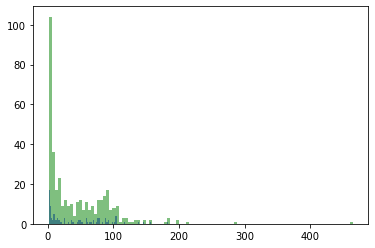

In [188]:
# import matplotlib.pyplot as plt

# x = [value1, value2, value3,....]
plt.hist([length_of_itemcode[x] for x in man_matched_set], bins=100, color='b', alpha=.5)
plt.hist([length_of_itemcode[x] for x in length_of_itemcode], bins=100, color='g', alpha=.5)
plt.show()

In [189]:
max([length_of_itemcode[x] for x in length_of_itemcode])

465